In [1]:
!nvidia-smi

Sun Dec 27 11:15:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports and Utility functions

## <font color='orange'>Imports</font>

In [1]:
#!pip3 install torchsummary torchviz tabulate scikit-video

     |████████████████████████████████| 41 kB 222 kB/s eta 0:00:011
     |████████████████████████████████| 2.3 MB 16.6 MB/s eta 0:00:01
  Created wheel for torchviz: filename=torchviz-0.0.1-py3-none-any.whl size=3520 sha256=fec3fcde4407e793bff4e9b68af6b06c678905861171cb873fb872b4a05a7c08
  Stored in directory: /home/umapada/.cache/pip/wheels/89/b0/3c/fd769174401ef5d43e18d047b509b91f8635f8fba6dacaf4f6
Successfully built torchviz


In [1]:
import numpy as np
import pandas as pd
import shutil, time, os, requests, random, copy
from itertools import permutations 
import seaborn as sns
import imageio
from skimage.transform import rotate, AffineTransform, warp, resize
import skvideo.io as vidio
#from google.colab.patches import cv2_imshow
from IPython.display import clear_output, Image, SVG
import h5py
from tabulate import tabulate

import torch
import torch.nn as nn
import torch.nn.functional as tF
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as dset
from torchvision import datasets, transforms, models
from torchviz import make_dot
from torchsummary import summary

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
#import matplotlib.animation as animation
%matplotlib inline

In [2]:
np.random.seed(16)
torch.manual_seed(16)
#tf.random.set_seed(16)

In [154]:
!apt-get install p7zip-full

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


## <font color='orange'>Analysing and Cleaning Data</font>

In [ ]:
!wget http://download.cs.stanford.edu/deep/MRNet-v1.0.zip

--2020-12-24 10:12:55--  http://download.cs.stanford.edu/deep/MRNet-v1.0.zip
Resolving download.cs.stanford.edu (download.cs.stanford.edu)... 171.64.64.22
Connecting to download.cs.stanford.edu (download.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6087523606 (5.7G) [application/zip]
Saving to: ‘MRNet-v1.0.zip’

MRNet-v1.0.zip      100%[===================>]   5.67G  2.19MB/s    in 47m 59s 

2020-12-24 11:00:55 (2.02 MB/s) - ‘MRNet-v1.0.zip’ saved [6087523606/6087523606]



In [ ]:
!7z e MRNet-v1.0.zip 


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 6087523606 bytes (5806 MiB)

Extracting archive: MRNet-v1.0.zip
  6% 256 Open              13% 512 Open              20% 768 Open              27% 1024 Open               33% 1280 Open               40% 1536 Open               47% 1792 Open               54% 2048 Open               60% 2304 Open               67% 2560 Open               74% 2816 Open               81% 3072 Open               

In [ ]:
!unzip MRNet-v1.0.zip -d ~/MRNet

Archive:  MRNet-v1.0.zip
warning [MRNet-v1.0.zip]:  4294967296 extra bytes at beginning or within zipfile
  (attempting to process anyway)
file #1:  bad zipfile offset (local header sig):  4294967296
  (attempting to re-compensate)
error: invalid zip file with overlapped components (possible zip bomb)


In [ ]:
!ls ~/MRNet/MRNet-v1.0/

In [ ]:
!rm -rf MRNet-v1.0.zip

## UCF 11

In [5]:
!wget https://www.crcv.ucf.edu/data/UCF11_updated_mpg.rar --no-check-certificate

--2020-12-27 11:15:40--  https://www.crcv.ucf.edu/data/UCF11_updated_mpg.rar
Resolving www.crcv.ucf.edu (www.crcv.ucf.edu)... 132.170.214.127
Connecting to www.crcv.ucf.edu (www.crcv.ucf.edu)|132.170.214.127|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 1045106394 (997M) [application/rar]
Saving to: ‘UCF11_updated_mpg.rar’

UCF11_updated_mpg.r 100%[===================>] 996.69M  84.9MB/s    in 12s     

2020-12-27 11:15:52 (85.6 MB/s) - ‘UCF11_updated_mpg.rar’ saved [1045106394/1045106394]



In [6]:
!mkdir /content/UCF11/

In [7]:
!unrar x -r /content/UCF11_updated_mpg.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/UCF11_updated_mpg.rar

Creating    UCF11_updated_mpg                                         OK
Creating    UCF11_updated_mpg/basketball                              OK
Creating    UCF11_updated_mpg/basketball/v_shooting_01                OK
Extracting  UCF11_updated_mpg/basketball/v_shooting_01/v_shooting_01_01.mpg       0%  OK 
Extracting  UCF11_updated_mpg/basketball/v_shooting_01/v_shooting_01_02.mpg       0%  OK 
Extracting  UCF11_updated_mpg/basketball/v_shooting_01/v_shooting_01_03.mpg       0%  OK 
Extracting  UCF11_updated_mpg/basketball/v_shooting_01/v_shooting_01_04.mpg       0%  OK 
Extracting  UCF11_updated_mpg/basketball/v_shooting_01/v_shooting_01_05.mpg       0%  OK 
Extracting  UCF11_updated_mpg/basketball/v_shooting_01/v_shooting_01_06.mpg       0%  OK 
Extracting  UCF11_updated_mpg/basketball/v_shooting_01/v_shooting_01_0

In [8]:
ucf_classes = os.listdir('/content/UCF11_updated_mpg/')

In [9]:
!ls /content/UCF11_updated_mpg

basketball  golf_swing	     swing		 volleyball_spiking
biking	    horse_riding     tennis_swing	 walking
diving	    soccer_juggling  trampoline_jumping


In [10]:
for c in ucf_classes:
    path = '/content/UCF11_updated_mpg/' + c
    os.makedirs('/content/UCF11/'+c)
    for f in os.listdir(path):
        files = os.listdir(path+'/'+f)
        for fi in files:
            shutil.move('/'.join([path,f,fi]),'/content/UCF11/'+c)

In [11]:
!rm -rf UCF11_updated_mpg

In [12]:
!ls /content/UCF11/

basketball  golf_swing	     swing		 volleyball_spiking
biking	    horse_riding     tennis_swing	 walking
diving	    soccer_juggling  trampoline_jumping


In [13]:
filenames_df = pd.DataFrame(columns=['filename','action'])

for c in ucf_classes:
    path = '/content/UCF11/'+c
    filenames = os.listdir(path)
    filenames = [f for f in filenames if '.mpg' in f]
    lendf = len(filenames_df)
    for i in range(lendf,lendf+len(filenames)):
        filenames_df = filenames_df.append({'filename':'/'.join([path,filenames[i-lendf]]),'action':c},ignore_index=True) 

In [14]:
filenames_df = filenames_df.sample(frac=1).reset_index(drop=True)

In [15]:
filenames_df

,filename,action
0,/content/UCF11/basketball/v_shooting_21_04.mpg,basketball
1,/content/UCF11/horse_riding/v_riding_13_04.mpg,horse_riding
2,/content/UCF11/trampoline_jumping/v_jumping_07...,trampoline_jumping
3,/content/UCF11/soccer_juggling/v_juggle_17_07.mpg,soccer_juggling
4,/content/UCF11/swing/v_swing_09_04.mpg,swing
...,...,...
1595,/content/UCF11/golf_swing/v_golf_19_03.mpg,golf_swing
1596,/content/UCF11/soccer_juggling/v_juggle_12_03.mpg,soccer_juggling
1597,/content/UCF11/swing/v_swing_17_03.mpg,swing
1598,/content/UCF11/golf_swing/v_golf_12_02.mpg,golf_swing


## Files

In [3]:
!ls /mnt/disks/data/GCP/Stanford\ MRNet-v1/MRNet-v1.0/

tr_multilabel.csv   train-acl.csv	valid		    valid-meniscus.csv
train		    train-meniscus.csv	valid-abnormal.csv  valid_labels.csv
train-abnormal.csv  train_labels.csv	valid-acl.csv


In [3]:
mrnet_path = '/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1.0/'
contents = os.listdir(mrnet_path)
print(contents)
print('\nLabel Files...')
label_files = [x for x in contents if x.endswith('.csv')]
print(label_files)

['valid-abnormal.csv', 'train-meniscus.csv', 'valid-acl.csv', 'valid_labels.csv', 'tr_multilabel.csv', '.DS_Store', 'valid-meniscus.csv', 'train-abnormal.csv', 'train', 'valid', 'train_labels.csv', 'train-acl.csv']

Label Files...
['valid-abnormal.csv', 'train-meniscus.csv', 'valid-acl.csv', 'valid_labels.csv', 'tr_multilabel.csv', 'valid-meniscus.csv', 'train-abnormal.csv', 'train_labels.csv', 'train-acl.csv']


In [4]:
'''#Needs to be done once
classes = ['axial','sagittal','coronal']
fileToBeDeleted = '.DS_Store'
for c in classes:
    os.remove(mrnet_path+'/train/'+c+'/'+fileToBeDeleted)
print(fileToBeDeleted in os.listdir(mrnet_path+'/train/axial'))
print(fileToBeDeleted in os.listdir(mrnet_path+'/train/sagittal'))
print(fileToBeDeleted in os.listdir(mrnet_path+'/train/coronal'))'''

"#Needs to be done once\nclasses = ['axial','sagittal','coronal']\nfileToBeDeleted = '.DS_Store'\nfor c in classes:\n    os.remove(mrnet_path+'/train/'+c+'/'+fileToBeDeleted)\nprint(fileToBeDeleted in os.listdir(mrnet_path+'/train/axial'))\nprint(fileToBeDeleted in os.listdir(mrnet_path+'/train/sagittal'))\nprint(fileToBeDeleted in os.listdir(mrnet_path+'/train/coronal'))"

### Real Labels

In [4]:
#For Colab /root/MRNet/MRNet-v1.0/
trabn = pd.read_csv(mrnet_path+'/train-abnormal.csv',header=None)
#trabn.head()
tracl = pd.read_csv(mrnet_path+'/train-acl.csv',header=None)
#tracl.head()
trmen = pd.read_csv(mrnet_path+'/train-meniscus.csv',header=None)
#trmen.head()

In [5]:
trabn.columns = ['patient_id','label']
tracl.columns = ['patient_id','label']
trmen.columns = ['patient_id','label']

In [6]:
tr_multilabel = trabn.merge(tracl,on='patient_id').merge(trmen,on='patient_id')
tr_multilabel.columns = ['patient_id','abn','acl','men']
tr_multilabel.head()

,patient_id,abn,acl,men
0,0,1,0,0
1,1,1,1,1
2,2,1,0,0
3,3,1,0,1
4,4,1,0,0


In [7]:
tr_multilabel.to_csv('tr_multilabl.csv',header=True)

In [8]:
#For Colab /root/MRNet/MRNet-v1.0/
valabn = pd.read_csv(mrnet_path+'/valid-abnormal.csv',header=None)
valacl = pd.read_csv(mrnet_path+'/valid-acl.csv',header=None)
valmen = pd.read_csv(mrnet_path+'/valid-meniscus.csv',header=None)

In [9]:
valabn.columns = ['patient_id','label']
valacl.columns = ['patient_id','label']
valmen.columns = ['patient_id','label']

In [10]:
val_multilabel = valabn.merge(valacl,on='patient_id').merge(valmen,on='patient_id')
val_multilabel.columns = ['patient_id','abn','acl','men']
val_multilabel.head(120)

,patient_id,abn,acl,men
0,1130,0,0,0
1,1131,0,0,0
2,1132,0,0,0
3,1133,0,0,0
4,1134,0,0,0
...,...,...,...,...
115,1245,1,1,1
116,1246,1,1,1
117,1247,1,0,1
118,1248,1,1,1


### <font color='blue'>Filename DataFrame</font>

In [11]:
ax_tr_filenames_df = pd.DataFrame(columns=['patient_id','filename'])
ax_tr_filenames_df['filename'] = os.listdir(mrnet_path+'train/axial')

ax_tr_filenames_df['patient_id'] = ax_tr_filenames_df.apply(lambda x : int(x['filename'][:-4]),axis=1)
ax_tr_filenames_df['filename'] = ax_tr_filenames_df.apply(lambda x : mrnet_path+'train/axial/'+x['filename'],axis=1)

ax_tr_filenames_df = ax_tr_filenames_df[list(('patient_id','filename'))]
ax_tr_filenames_df.sort_values(by=['patient_id'],ascending=True,inplace=True,ignore_index=True)

ax_tr_filenames_df

,patient_id,filename
0,0,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
1,1,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
2,2,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
3,3,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
4,4,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
...,...,...
1125,1125,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
1126,1126,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
1127,1127,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
1128,1128,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...


In [12]:
sg_tr_filenames_df = pd.DataFrame(columns=['patient_id','filename'])
sg_tr_filenames_df['filename'] = os.listdir(mrnet_path+'train/sagittal')

sg_tr_filenames_df['patient_id'] = sg_tr_filenames_df.apply(lambda x : int(x['filename'][:-4]),axis=1)
sg_tr_filenames_df['filename'] = sg_tr_filenames_df.apply(lambda x : mrnet_path+'train/sagittal/'+x['filename'],axis=1)

sg_tr_filenames_df = sg_tr_filenames_df[list(('patient_id','filename'))]
sg_tr_filenames_df.sort_values(by=['patient_id'],ascending=True,inplace=True,ignore_index=True)

sg_tr_filenames_df

,patient_id,filename
0,0,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
1,1,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
2,2,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
3,3,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
4,4,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
...,...,...
1125,1125,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
1126,1126,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
1127,1127,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
1128,1128,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...


In [13]:
cr_tr_filenames_df = pd.DataFrame(columns=['patient_id','filename'])
cr_tr_filenames_df['filename'] = os.listdir(mrnet_path+'train/coronal')

cr_tr_filenames_df['patient_id'] = cr_tr_filenames_df.apply(lambda x : int(x['filename'][:-4]),axis=1)
cr_tr_filenames_df['filename'] = cr_tr_filenames_df.apply(lambda x : mrnet_path+'train/coronal/'+x['filename'],axis=1)

cr_tr_filenames_df = cr_tr_filenames_df[list(('patient_id','filename'))]
cr_tr_filenames_df.sort_values(by=['patient_id'],ascending=True,inplace=True,ignore_index=True)

cr_tr_filenames_df

,patient_id,filename
0,0,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
1,1,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
2,2,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
3,3,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
4,4,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
...,...,...
1125,1125,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
1126,1126,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
1127,1127,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
1128,1128,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...


In [14]:
ax_val_filenames_df = pd.DataFrame(columns=['patient_id','filename'])
ax_val_filenames_df['filename'] = os.listdir(mrnet_path+'valid/axial')

ax_val_filenames_df['patient_id'] = ax_val_filenames_df.apply(lambda x : int(x['filename'][:-4]),axis=1)
ax_val_filenames_df['filename'] = ax_val_filenames_df.apply(lambda x : mrnet_path+'valid/axial/'+x['filename'],axis=1)

ax_val_filenames_df = ax_val_filenames_df[list(('patient_id','filename'))]
ax_val_filenames_df.sort_values(by=['patient_id'],ascending=True,inplace=True,ignore_index=True)

ax_val_filenames_df

,patient_id,filename
0,1130,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
1,1131,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
2,1132,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
3,1133,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
4,1134,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
...,...,...
115,1245,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
116,1246,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
117,1247,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
118,1248,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...


In [15]:
ax_val_filenames_df['filename'].iloc[0]

'/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1.0/valid/axial/1130.npy'

In [16]:
sg_val_filenames_df = pd.DataFrame(columns=['patient_id','filename'])
sg_val_filenames_df['filename'] = os.listdir(mrnet_path+'valid/sagittal')

sg_val_filenames_df['patient_id'] = sg_val_filenames_df.apply(lambda x : int(x['filename'][:-4]),axis=1)
sg_val_filenames_df['filename'] = sg_val_filenames_df.apply(lambda x : mrnet_path+'valid/sagittal/'+x['filename'],axis=1)

sg_val_filenames_df = sg_val_filenames_df[list(('patient_id','filename'))]
sg_val_filenames_df.sort_values(by=['patient_id'],ascending=True,inplace=True,ignore_index=True)

sg_val_filenames_df

,patient_id,filename
0,1130,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
1,1131,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
2,1132,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
3,1133,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
4,1134,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
...,...,...
115,1245,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
116,1246,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
117,1247,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
118,1248,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...


In [17]:
cr_val_filenames_df = pd.DataFrame(columns=['patient_id','filename'])
cr_val_filenames_df['filename'] = os.listdir(mrnet_path+'valid/coronal')

cr_val_filenames_df['patient_id'] = cr_val_filenames_df.apply(lambda x : int(x['filename'][:-4]),axis=1)
cr_val_filenames_df['filename'] = cr_val_filenames_df.apply(lambda x : mrnet_path+'valid/coronal/'+x['filename'],axis=1)

cr_val_filenames_df = cr_val_filenames_df[list(('patient_id','filename'))]
cr_val_filenames_df.sort_values(by=['patient_id'],ascending=True,inplace=True,ignore_index=True)

cr_val_filenames_df

,patient_id,filename
0,1130,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
1,1131,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
2,1132,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
3,1133,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
4,1134,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
...,...,...
115,1245,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
116,1246,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
117,1247,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...
118,1248,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...


## <font color='orange'>Visualizing the Data</font>

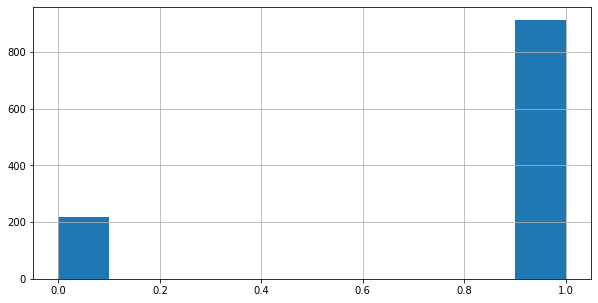

In [ ]:
trabn.iloc[:,1].hist(figsize = (10, 5))

In [ ]:
np.count_nonzero(trabn.iloc[:,1]==1)

913

In [ ]:
tracl.iloc[:,1].hist(figsize = (10, 5))

In [ ]:
np.count_nonzero(tracl.iloc[:,1]==1)

In [ ]:
trmen.iloc[:,1].hist(figsize = (10, 5))

In [ ]:
np.count_nonzero(trmen.iloc[:,1]==1)

In [ ]:
tr_multilabel.iloc[:,1:].hist(figsize = (10, 5))

In [ ]:
ps_labels = tr_multilabel
ps_labels.head()

In [ ]:
tr_multilabel['label'] = tr_multilabel.apply(lambda x : 4*x["abn"]+2*x["acl"]+1*x["men"],axis=1)

In [ ]:
tr_multilabel

In [ ]:
tr_multilabel.iloc[:,4].hist(figsize = (10, 5))

In [ ]:
label_map = {0:0,4:1,5:2,6:3,7:4}

In [ ]:
ps_labels['label'] = ps_labels['label'].apply(lambda x : label_map[x])

In [ ]:
ps_labels

In [ ]:
ps_labels['label'].plot.hist(bins = [-0.5,0.5,1.5,2.5,3.5,4.5],figsize = (10, 5))

In [ ]:
tr_multilabel = tr_multilabel.drop(['label'],axis=1)

### Oversampling

In [ ]:
proportions = np.array([])
for i in range(5):
    proportions = np.append(proportions,np.count_nonzero(tr_filenames_df['aclDiagnosis']==i))
        
proportions = np.min(proportions)/proportions
print(proportions)

In [ ]:
mult = proportions/min(proportions)

In [ ]:
mult

In [ ]:
for i in range(5):
    print(len(tr_multilabel))
    if mult[i]>1:
        currlabnum = np.count_nonzero(tr_multilabel['label']==i)
        finallabnum = int(np.ceil(mult[i]*currlabnum))
        print(currlabnum,finallabnum)
        gapnum = finallabnum-currlabnum
        labdf = tr_multilabel[tr_multilabel['label']==i]
        oversampled_labdf = labdf.sample(n=gapnum,replace=True)
        tr_multilabel = tr_multilabel.append(oversampled_labdf)
        print(len(tr_multilabel))
        tr_multilabel['label'].hist(bins=[-0.5,0.5,1.5,2.5,3.5,4.5])

In [ ]:
tr_multilabel = tr_multilabel.sample(frac=1,random_state=69)

In [ ]:
tr_multilabel

In [ ]:
val_multilabel.plot.hist(bins=[-0.5,0.5,1.5,2.5,3.5,4.5])

## KneeMRI DATASET

In [ ]:
!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/volumetric_data/vol01.7z

In [ ]:
!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/volumetric_data/vol02.7z

In [ ]:
!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/volumetric_data/vol03.7z

In [ ]:
!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/volumetric_data/vol04.7z

In [ ]:
!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/volumetric_data/vol05.7z

In [ ]:
!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/volumetric_data/vol06.7z

In [ ]:
!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/volumetric_data/vol07.7z

In [ ]:
!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/volumetric_data/vol08.7z

In [ ]:
!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/volumetric_data/vol09.7z

In [ ]:
!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/volumetric_data/vol10.7z

In [ ]:
!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/metadata.csv

In [ ]:
!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/volumetric_data/example.pck

In [ ]:
!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/example.py

## <font color='orange'>Utility Functions</font>

### <font color='blue'>Declaring the required PATH variables</font>

In [18]:
#For Colab '/root/MRNet/MRNet-v1.0/'

train_dir = mrnet_path+'/train'
valid_dir = mrnet_path+'/valid'
axial_mode= 'axial'
sagit_mode='sagittal'
coron_mode='coronal'
base_dir = mrnet_path

'''access_token = '1094213176:AAFPM2lzoWH_fvQXgDjUtluJCctamMp5Ax0'
NUM_FRAMES = 1
batch_size = 8 #32
NUM_CLASSES = 500 #3
NUM_PATCHES = 9'''

"access_token = '1094213176:AAFPM2lzoWH_fvQXgDjUtluJCctamMp5Ax0'\nNUM_FRAMES = 1\nbatch_size = 8 #32\nNUM_CLASSES = 500 #3\nNUM_PATCHES = 9"

### <font color='blue'>Performance Metrics</font>

In [19]:
#util_wk2
def TP(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 1))


def TN(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 0))


def FN(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 1))


def FP(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 0))

def get_accuracy(y, pred, th=0.5):
    tp = TP(y,pred,th)
    fp = FP(y,pred,th)
    tn = TN(y,pred,th)
    fn = FN(y,pred,th)
    
    return (tp+tn)/(tp+fp+tn+fn)

def get_prevalence(y):
    return np.sum(y)/y.shape[0]

def sensitivity(y, pred, th=0.5):
    tp = TP(y,pred,th)
    fn = FN(y,pred,th)
    
    return tp/(tp+fn)

def specificity(y, pred, th=0.5):
    tn = TN(y,pred,th)
    fp = FP(y,pred,th)
    
    return tn/(tn+fp)

def get_ppv(y, pred, th=0.5):
    tp = TP(y,pred,th)
    fp = FP(y,pred,th)
    
    return tp/(tp+fp)

def get_npv(y, pred, th=0.5):
    tn = TN(y,pred,th)
    fn = FN(y,pred,th)
    
    return tn/(tn+fn)


def get_performance_metrics(y, pred, class_labels, tp=TP,
                            tn=TN, fp=FP,
                            fn=FN,
                            acc=get_accuracy, prevalence=get_prevalence, 
                            spec=specificity,sens=sensitivity, ppv=get_ppv, 
                            npv=get_npv, auc=roc_auc_score, f1=f1_score,
                            thresholds=[]):
    if len(thresholds) != len(class_labels):
        thresholds = [.5] * len(class_labels)

    columns = ["", "TP", "TN", "FP", "FN", "Accuracy", "Prevalence",
               "Sensitivity",
               "Specificity", "PPV", "NPV", "AUC", "F1", "Threshold"]
    df = pd.DataFrame(columns=columns)
    for i in range(len(class_labels)):
        df.loc[i] = [""] + [0] * (len(columns) - 1)
        df.loc[i][0] = class_labels[i]
        df.loc[i][1] = round(tp(y[:, i], pred[:, i]),
                             3) if tp != None else "Not Defined"
        df.loc[i][2] = round(tn(y[:, i], pred[:, i]),
                             3) if tn != None else "Not Defined"
        df.loc[i][3] = round(fp(y[:, i], pred[:, i]),
                             3) if fp != None else "Not Defined"
        df.loc[i][4] = round(fn(y[:, i], pred[:, i]),
                             3) if fn != None else "Not Defined"
        df.loc[i][5] = round(acc(y[:, i], pred[:, i], thresholds[i]),
                             3) if acc != None else "Not Defined"
        df.loc[i][6] = round(prevalence(y[:, i]),
                             3) if prevalence != None else "Not Defined"
        df.loc[i][7] = round(sens(y[:, i], pred[:, i], thresholds[i]),
                             3) if sens != None else "Not Defined"
        df.loc[i][8] = round(spec(y[:, i], pred[:, i], thresholds[i]),
                             3) if spec != None else "Not Defined"
        df.loc[i][9] = round(ppv(y[:, i], pred[:, i], thresholds[i]),
                             3) if ppv != None else "Not Defined"
        df.loc[i][10] = round(npv(y[:, i], pred[:, i], thresholds[i]),
                              3) if npv != None else "Not Defined"
        df.loc[i][11] = round(auc(y[:, i], pred[:, i]),
                              3) if auc != None else "Not Defined"
        df.loc[i][12] = round(f1(y[:, i], pred[:, i] > thresholds[i]),
                              3) if f1 != None else "Not Defined"
        df.loc[i][13] = round(thresholds[i], 3)

    df = df.set_index("")
    return df

def bootstrap_metric(y, pred, classes, metric='auc',bootstraps = 100, fold_size = 1000):
    statistics = np.zeros((len(classes), bootstraps))
    if metric=='AUC':
        metric_func = roc_auc_score
    if metric=='Sensitivity':
        metric_func = sensitivity
    if metric=='Specificity':
        metric_func = specificity
    if metric=='Accuracy':
        metric_func = get_accuracy
    for c in range(len(classes)):
        df = pd.DataFrame(columns=['y', 'pred'])
        df.loc[:, 'y'] = y[:, c]
        df.loc[:, 'pred'] = pred[:, c]
        # get positive examples for stratified sampling
        df_pos = df[df.y == 1]
        df_neg = df[df.y == 0]
        prevalence = len(df_pos) / len(df)
        for i in range(bootstraps):
            # stratified sampling of positive and negative examples
            pos_sample = df_pos.sample(n = int(fold_size * prevalence), replace=True)
            neg_sample = df_neg.sample(n = int(fold_size * (1-prevalence)), replace=True)

            y_sample = np.concatenate([pos_sample.y.values, neg_sample.y.values])
            pred_sample = np.concatenate([pos_sample.pred.values, neg_sample.pred.values])
            score = metric_func(y_sample, pred_sample)
            statistics[c][i] = score
    return statistics

def get_confidence_intervals(y,pred,class_labels):
    
    metric_dfs = {}
    for metric in ['AUC','Sensitivity','Specificity','Accuracy']:
        statistics = bootstrap_metric(y,pred,class_labels,metric)
        df = pd.DataFrame(columns=["Mean "+metric+" (CI 5%-95%)"])
        for i in range(len(class_labels)):
            mean = statistics.mean(axis=1)[i]
            max_ = np.quantile(statistics, .95, axis=1)[i]
            min_ = np.quantile(statistics, .05, axis=1)[i]
            df.loc[class_labels[i]] = ["%.2f (%.2f-%.2f)" % (mean, min_, max_)]
        metric_dfs[metric] = df
    return metric_dfs


### <font color='blue'>Plotting Metrics</font>

#### <font color='red'>Accuracy</font>

In [20]:
def plot_accuracy(tr_acc,val_acc):
    # Plot training & validation accuracy values
    plt.plot(tr_acc)
    plt.plot(val_acc)
    plt.title('Model accuracy',fontsize=10)
    plt.ylabel('Accuracy',fontsize=10)
    plt.xlabel('Epoch',fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.legend(['Train', 'Validation'], loc='upper left',prop={'size': 10})
    plt.savefig('accuracy_plot.png')
    plt.show()

#### <font color='red'>Loss</font>

In [21]:
def plot_loss(tr_loss,val_loss):
    # Plot training & validation loss values
    plt.plot(tr_loss)
    plt.plot(val_loss)
    plt.title('Model loss',fontsize=10)
    plt.ylabel('Loss',fontsize=10)
    plt.xlabel('Epoch',fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.legend(['Train', 'Validation'], loc='upper left',prop={'size': 10})
    plt.savefig('loss_plot.png')
    plt.show()

#### <font color='red'>ROC</font>

In [22]:
def get_roc_curve(gt, pred, target_names):
    for i in range(len(target_names)):
        curve_function = roc_curve
        auc_roc = roc_auc_score(gt[:, i], pred[:, i])
        label = str(target_names[i]) + " AUC: %.3f " % auc_roc
        xlabel = "False positive rate"
        ylabel = "True positive rate"
        a, b, _ = curve_function(gt[:, i], pred[:, i])
        plt.figure(1, figsize=(7, 7))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(a, b, label=label)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)
        plt.savefig('ROC_Curve.png')
        plt.show()

#### <font color='red'>Precision and Recall</font>

In [23]:
def get_PR_curve(gt, pred, target_names):
    for i in range(len(target_names)):
        precision, recall, _ = precision_recall_curve(gt[:, i], pred[:, i])
        average_precision = average_precision_score(gt[:, i], pred[:, i])
        label = str(target_names[i]) + " Avg.: %.3f " % average_precision
        plt.figure(1, figsize=(7, 7))
        plt.step(recall, precision, where='post', label=label)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)
        plt.savefig('Precision_and_Recall_curve.png')
        plt.show()

#### <font color='red'>Confusion Matrix</font>  

In [24]:
def plot_confusion_matrix(y_true,y_pred,class_labels):
    cm = confusion_matrix(y_true, y_pred, labels=class_labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=class_labels, columns=class_labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=(60,60))
    sns.set(font_scale=3.0) # Adjust to fit
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    ax.tick_params(axis='both', which='major', labelsize=10)  # Adjust to fit
    ax.xaxis.set_ticklabels(class_labels)
    ax.yaxis.set_ticklabels(class_labels)
    fig.savefig('Confusion_Matrix.png')
    plt.show()

#### <font color='red'>Performance Metrics with Errorbars</font>

In [25]:
#04_03_Errorbar.ipynb
def plot_perf_metrics_errbars(y,pred,class_labels):
    metric_dfs = get_confidence_intervals(y,pred,class_labels)
    metrics = metric_dfs.keys()
    fig,axs = plt.subplots(len(metrics),1,sharey=True)
    for i in range(len(metrics)):
        ci = metric_dfs[metric][['Mean '+metrics[i]+' (CI 5%-95%)']].values
        ci_mean,ci_ints = np.array([c[0].split(' ') for c in ci]).T
        ci_mean = ci_mean.astype(float)
        ci_min,ci_max = np.array([ci_ints.strip('()').split('-')]).astype(float)
        ci_err = (ci_max-ci_min)/2
        
        axs[i].errorbar(class_labels,ci_mean,yerr=ci_err,capsize=5,fmt='dk')
        axs[i].set_ylabel(metrics[i])
    fig.savefig('Performance_Metrics_95percentCI.png')
    plt.show()

# <font color='green'>Approach 1 : Jumbled Patch Order Prediction</font> 

# TEMPORAL ORDER VERIFICATION



## <font color='orange'>Preparing Pseudo Labels</font>

NEEDS TO BE RUN


In [26]:
def build_pseudo_GTP_labels():
    ROTATION = [-15,0,15]
    TRANSLATEX = [-6,0,6]
    TRANSLATEY = [-6,0,6]
    SCALING = [1,1.1]
    SHEAR = []
    classes = {}
    cind = 0
    for rot in ROTATION:
        for tranX in TRANSLATEX:
            for tranY in TRANSLATEY:
                for sc in SCALING:
                    classes[cind] = [rot,tranX,tranY,sc]
                    cind+=1
    return classes


GTP_LABELS = build_pseudo_GTP_labels()

In [ ]:
#GTP_LABELS

### PPP Pseudo Labels

In [ ]:
NUM_PATCHES = 9

In [ ]:
def build_pseudo_ppp_labels(num_patches):
    ppp_labels_perms = list(permutations(range(0,num_patches)))
    ppp_labels_perms = [list(t) for t in ppp_labels_perms]
    #print(ppp_labels_perms)

    ppp_labels = {}
    label_num= 0
    for key in ppp_labels_perms:
        ppp_labels[str(key)] = label_num
        label_num+=1
    
    return ppp_labels

PPP_LABELS = build_pseudo_ppp_labels(NUM_PATCHES)

keys = random.sample(list(PPP_LABELS.keys()),500)
if '[0, 1, 2, 3, 4, 5, 6, 7, 8]' not in keys:
    PPP_LABELS_DICT = {'[0, 1, 2, 3, 4, 5, 6, 7, 8]':0}
    keys = keys[:-1]
    v = 1
else:
    v = 0
for k in keys:
    PPP_LABELS_DICT[k] = v
    v+=1

PPP_LABELS = PPP_LABELS_DICT
#print(PPP_LABELS_DICT)

In [ ]:
#print(PPP_LABELS)

## Frame Shuffling

### Steps
Choose a random video and take 5 frames

Choose two transformations

Choose another video for making negative pair with the previous sample. 

Store a negative pair with similarity score close to 1 as HNP

Also choose non overlapping frames from same clip as the anchor sample as negative pair



In [ ]:
class gridshuffler():
    def __init__(self,num_patches):
        self.num_patches = num_patches
        
    def 
    ppp_labels = list(self.ppp_labels_dict.keys())
        #print(len(ppp_labels))
        crop_window = int(256/int(np.sqrt(self.num_patches)))
        crop_window_rlx = 64 #################################int(crop_window - np.ceil(0.2*float(crop_window)))
        eachgap = int((crop_window-crop_window_rlx)/2.)
    
        label_idx = np.random.choice(list(range(self.num_classes)))
        #print(ppp_labels[label_idx])
        jumbling_order = list(map(int,ppp_labels[label_idx].strip('[]').split(',')))
        temp_batch_img = np.zeros((64,64,3))
        for jo in range(len(jumbling_order)):
            temp_patch1 = np.zeros((crop_window_rlx,crop_window_rlx,3))
            spatch_num = jumbling_order[jo]
            scol_num = spatch_num%int(np.sqrt(self.num_patches))
            srow_num = int(np.floor(spatch_num/int(np.sqrt(self.num_patches))))
            gapx = np.random.randint(0,eachgap)
            gapy = np.random.randint(0,eachgap)
            sourcesx = crop_window*scol_num + gapx
            sourceex = sourcesx + crop_window_rlx
            sourcesy = crop_window*srow_num + gapy
            sourceey = sourcesy + crop_window_rlx

            #AUGMENT FRAMES
            if self.phase=='train':
                temp_patch1 = self.__augment(imgs[sourcesx:sourceex,sourcesy:sourceey,:])
            else:
                temp_patch1 = imgs[sourcesx:sourceex,sourcesy:sourceey,:]

            inputs = np.append(inputs,np.expand_dims(np.transpose(temp_patch1),axis=0),axis=0)

            labels = int(self.ppp_labels_dict[ppp_labels[label_idx]])

        #PREPROCESS FRAMES
        inputs = self.preprocess_input(inputs)

In [26]:
#Shuffle the frames
class FrameShuffler():
    def __init__(self,num_frames):
        self.num_frames = num_frames
        self.frame_perms = [list(p) for p in list(permutations(range(0,self.num_frames)))]
        
    def hamming_dist(self,t1,t2):
        dist = 0
        for i in range(len(t1)):
            if t1[i]!=t2[i]:
                dist+=1
        return dist

    def shuffle_clip(self,clip,p,t = None):
        t_new = random.choice(self.frame_perms)
        if t is not None:
            if p:
                while t == t_new or self.hamming_dist(t,t_new) < 4:
                    t_new = random.choice(self.frame_perms)
            else:
                while t == t_new or self.hamming_dist(t,t_new) > 2:
                    t_new = random.choice(self.frame_perms)
        #print(t_new)
        T,H,W,C = clip.shape
        new_clip = np.array([]).reshape([0,H,W,C])
        for i in range(self.num_frames):
            new_clip = np.append(new_clip,clip[[t_new[i]]],axis=0)
        
        return new_clip, t_new

    def pick_frames(self,vid,start_frame = None):
        if start_frame is None:
            start_frame = random.randint(0,vid.shape[0]-self.num_frames*2)
        return vid[start_frame:start_frame+self.num_frames,:,:,:], start_frame

    def apply_shuffle(self,clip,t):
        T,H,W,C = list(clip.shape)
        #print(clip.shape)
        new_clip = np.array([]).reshape([0,H,W,C])
        for i in range(self.num_frames):
            new_clip = np.append(new_clip,clip[[t[i]]],axis=0)
        #print(new_clip.shape)
        return new_clip, t

#Generate the pairs: 1) Choose the samples, 2) Select the frames, 3) Shuffle

class PairGenerator():
    def __init__(self,filenames_df,num_frames):
        self.filenames_df = filenames_df
        #self.positive = positive
        self.num_files = len(self.filenames_df)
        self.pair = []
        self.num_frames = num_frames
        self.shuffler = FrameShuffler(self.num_frames)

    def get_sample(self):
        return self.filenames_df['filename'].iloc[random.randint(0,self.num_files-1)]
    
    def get_frames(self,path):
        npy_file = np.load(path)
        tot_frames = npy_file.shape[0]
        '''frame_idxs = np.random.randint(0,tot_frames,size=self.num_frames)
        frames = np.array(image_volume[frame_idxs,:,:])'''
        #print(frames.shape)
        video = np.array([]).reshape((0,256,256,3))
        for f in range(tot_frames):
            frame = np.expand_dims(npy_file[f],axis=2)
            for i in range(3):
                video = np.append(video,np.expand_dims(np.repeat(frame,3,axis=2),axis=0),axis=0)
        
        return video
    
    def read_video(self,path):
        return self.get_frames(path)

    def get_pos_pair(self):
        sample = self.get_sample()
        video = self.read_video(sample)
        #print(video.shape)
        if video.shape[0]<self.num_frames:
            video = np.repeat(video,self.num_frames*2,axis = 0)
        clip, sf = self.shuffler.pick_frames(video)
        #v1,so1 = self.shuffler.shuffle_clip(clip,True,None)
        v1, so1 = clip, [0,1,2,3,4]
        v2,so2 = self.shuffler.shuffle_clip(clip,True,so1)
        self.pair = [v1,v2]
        return self.pair, sample, sample, sf, sf, so1, so2

    def get_neg_pair(self):
        sample1 = self.get_sample()
        video1 = self.read_video(sample1)
        #print(video1.shape)
        if video1.shape[0]<self.num_frames:
            video1 = np.repeat(video1,self.num_frames*2,axis = 0)
            
        clip1, sf1 = self.shuffler.pick_frames(video1)
        v1,so1 = self.shuffler.shuffle_clip(clip1,False,None)

        #sample2 = self.get_sample()
        #video2 = self.read_video(sample2)
        #print(video2.shape)
        #if video2.shape[0]<self.num_frames:
        #    video2 = np.repeat(video2,self.num_frames*2,axis = 0)
        #clip2, sf2 = self.shuffler.pick_frames(video1)#,sf1 + random.randint(2,5))
        v2,so2 = self.shuffler.shuffle_clip(clip1,False,so1)

        self.pair = [v1,v2]
        
        return self.pair, sample1, sample1, sf1, sf1, so1, so2
        

In [28]:
gp = PairGenerator(sg_tr_filenames_df,5)

In [29]:
v,_,_,sf1,sf2,so1,so2 = gp.get_neg_pair()

In [30]:
print(sf1,sf2,so1,so2)

21 21 [2, 4, 3, 1, 0] [1, 4, 3, 2, 0]


In [ ]:
fig1,ax1 = plt.subplots(1,5,figsize=(500,100))
for i in range(5):
    #plt.figure()
    ax1[i].imshow(v[0][i].astype(int))
fig2,ax2 = plt.subplots(1,5,figsize=(500,100))
for i in range(5):
    #plt.figure()
    ax2[i].imshow(v[1][i].astype(int))


## TOV Data Generator for Contrastive Learning

### Since we are doing COntrastive LEarning so only 1 and 0 labels are required

In [27]:
import math
import numbers
import random
import warnings
from collections.abc import Sequence
from typing import Tuple, List, Optional

import torch
from PIL import Image
from torch import Tensor
#import torch.functional as F
import torchvision.transforms.functional as F

### Augmentations

#### Utils

In [28]:
def _setup_size(size, error_msg):
    if isinstance(size, numbers.Number):
        return int(size), int(size)

    if isinstance(size, Sequence) and len(size) == 1:
        return size[0], size[0]

    if len(size) != 2:
        raise ValueError(error_msg)

    return size


def _check_sequence_input(x, name, req_sizes):
    msg = req_sizes[0] if len(req_sizes) < 2 else " or ".join([str(s) for s in req_sizes])
    if not isinstance(x, Sequence):
        raise TypeError("{} should be a sequence of length {}.".format(name, msg))
    if len(x) not in req_sizes:
        raise ValueError("{} should be sequence of length {}.".format(name, msg))


def _setup_angle(x, name, req_sizes=(2, )):
    if isinstance(x, numbers.Number):
        if x < 0:
            raise ValueError("If {} is a single number, it must be positive.".format(name))
        x = [-x, x]
    else:
        _check_sequence_input(x, name, req_sizes)

    return [float(d) for d in x]

#### COlor Jitter

In [29]:
class ColorJitter(nn.Module):
    """Randomly change the brightness, contrast and saturation of an image.

    Args:
        brightness (float or tuple of float (min, max)): How much to jitter brightness.
            brightness_factor is chosen uniformly from [max(0, 1 - brightness), 1 + brightness]
            or the given [min, max]. Should be non negative numbers.
        contrast (float or tuple of float (min, max)): How much to jitter contrast.
            contrast_factor is chosen uniformly from [max(0, 1 - contrast), 1 + contrast]
            or the given [min, max]. Should be non negative numbers.
        saturation (float or tuple of float (min, max)): How much to jitter saturation.
            saturation_factor is chosen uniformly from [max(0, 1 - saturation), 1 + saturation]
            or the given [min, max]. Should be non negative numbers.
        hue (float or tuple of float (min, max)): How much to jitter hue.
            hue_factor is chosen uniformly from [-hue, hue] or the given [min, max].
            Should have 0<= hue <= 0.5 or -0.5 <= min <= max <= 0.5.
    """

    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0):
        super().__init__()
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue

        self.brightness_factor = 0
        self.contrast_factor = 0
        self.saturation_factor = 0
        self.hue_factor = 0

    def __name__(self):
        return 'ColorJitter'

    def get_params(self):
        return [self.brightness_factor, self.contrast_factor, self.saturation_factor, self.hue_factor]

    def get_instant_transform(self, bcsh):
        transforms_list = []
        b,c,s,h = bcsh
        if b is not None:
            transforms_list.append(transforms.Lambda(lambda img: F.adjust_brightness(img, b)))
        if c is not None:
            transforms_list.append(transforms.Lambda(lambda img: F.adjust_contrast(img, c)))
        if s is not None:
            transforms_list.append(transforms.Lambda(lambda img: F.adjust_saturation(img, s)))
        if h is not None:
            transforms_list.append(transforms.Lambda(lambda img: F.adjust_hue(img, h)))

        transform = transforms.Compose(transforms_list)
    
        return transform
    
    def get_transform(self):
        """Get a randomized transform to be applied on image.

        Arguments are same as that of __init__.

        Returns:
            Transform which randomly adjusts brightness, contrast and
            saturation in a random order.
        """
        transforms_list = []

        if self.brightness is not None:
            self.brightness_factor = random.uniform(max(0,1-self.brightness), 1+self.brightness)
            transforms_list.append(transforms.Lambda(lambda img: F.adjust_brightness(img, self.brightness_factor)))

        if self.contrast is not None:
            self.contrast_factor = random.uniform(max(0,1-self.contrast), 1+self.contrast)
            transforms_list.append((transforms.Lambda(lambda img: F.adjust_contrast(img, self.contrast_factor))))

        if self.saturation is not None:
            self.saturation_factor = random.uniform(max(0,1-self.saturation), 1+self.saturation)
            transforms_list.append((transforms.Lambda(lambda img: F.adjust_saturation(img, self.saturation_factor))))

        if self.hue is not None:
            self.hue_factor = random.uniform(-1*self.hue, self.hue)
            transforms_list.append((transforms.Lambda(lambda img: F.adjust_hue(img, self.hue_factor))))

        #random.shuffle(transforms_list)
        transform = transforms.Compose(transforms_list)

        return transform

#### Horizontal Flip

In [30]:
class HorizontalFlip(nn.Module):
    """Horizontally flip the given image randomly with a given probability.
    The image can be a PIL Image or a torch Tensor, in which case it is expected
    to have [..., H, W] shape, where ... means an arbitrary number of leading
    dimensions
    """

    def __init__(self):
        super().__init__()
        #self.p = p
    
    def __name__(self):
        return 'HorizontalFlip'
    
    def get_params(self):
        return True

    def get_instant_transform(self, p):
        if p:
            return transforms.Lambda(lambda img: F.hflip(img))
        else:
            return transforms.Lambda(lambda img: img)

    def get_transform(self):
        """
        Args:
            img (PIL Image or Tensor): Image to be flipped.

        Returns:
            PIL Image or Tensor: Randomly flipped image.
        """
        return transforms.Lambda(lambda img: F.hflip(img))

#### Random Rotation

In [31]:
class RandomRotation(nn.Module):
    """Rotate the image by angle.
    The image can be a PIL Image or a Tensor, in which case it is expected
    to have [..., H, W] shape, where ... means an arbitrary number of leading dimensions.

    Args:
        degrees (sequence or float or int): Range of degrees to select from.
            If degrees is a number instead of sequence like (min, max), the range of degrees
            will be (-degrees, +degrees).
        resample (int, optional): An optional resampling filter. See `filters`_ for more information.
            If omitted, or if the image has mode "1" or "P", it is set to PIL.Image.NEAREST.
            If input is Tensor, only ``PIL.Image.NEAREST`` and ``PIL.Image.BILINEAR`` are supported.
        expand (bool, optional): Optional expansion flag.
            If true, expands the output to make it large enough to hold the entire rotated image.
            If false or omitted, make the output image the same size as the input image.
            Note that the expand flag assumes rotation around the center and no translation.
        center (list or tuple, optional): Optional center of rotation, (x, y). Origin is the upper left corner.
            Default is the center of the image.
        fill (n-tuple or int or float): Pixel fill value for area outside the rotated
            image. If int or float, the value is used for all bands respectively.
            Defaults to 0 for all bands. This option is only available for Pillow>=5.2.0.
            This option is not supported for Tensor input. Fill value for the area outside the transform in the output
            image is always 0.

    .. _filters: https://pillow.readthedocs.io/en/latest/handbook/concepts.html#filters

    """

    def __init__(self, degrees, resample=False, expand=False, center=None, fill=None):
        super().__init__()
        self.degrees = _setup_angle(degrees, name="degrees", req_sizes=(2, ))

        if center is not None:
            _check_sequence_input(center, "center", req_sizes=(2, ))

        self.center = center

        self.resample = resample
        self.expand = expand
        self.fill = fill

        self.angle = 0

    def __name__(self):
        return 'RandomRotation'

    def get_params(self):
        return self.angle

    def get_instant_transform(self, angle):
        return transforms.Lambda(lambda img: F.rotate(img, angle, self.resample, self.expand, self.center, self.fill))

    def get_transform(self):
        """Get parameters for ``rotate`` for a random rotation.

        Returns:
            float: angle parameter to be passed to ``rotate`` for random rotation.
        """
        self.angle = float(torch.empty(1).uniform_(float(self.degrees[0]), float(self.degrees[1])).item())
        return transforms.Lambda(lambda img: F.rotate(img, self.angle, self.resample, self.expand, self.center, self.fill))


#### GrayScale

In [32]:
class Grayscale(nn.Module):
    """Randomly convert image to grayscale with a probability of p (default 0.1).
    The image can be a PIL Image or a Tensor, in which case it is expected
    to have [..., 3, H, W] shape, where ... means an arbitrary number of leading
    dimensions

    Args:
        p (float): probability that image should be converted to grayscale.

    Returns:
        PIL Image or Tensor: Grayscale version of the input image with probability p and unchanged
        with probability (1-p).
        - If input image is 1 channel: grayscale version is 1 channel
        - If input image is 3 channel: grayscale version is 3 channel with r == g == b

    """

    def __init__(self):
        super().__init__()
        #self.p = p

    def __name__(self):
        return 'Grayscale'

    def get_params(self):
        return True

    def get_instant_transform(self, p):
        if p:
            transforms.Lambda(lambda img: F.rgb_to_grayscale(img, num_output_channels=F._get_image_num_channels(img)))
        else:
            transforms.Lambda(lambda img: img)

    def get_transform(self):
        """
        Args:
            img (PIL Image or Tensor): Image to be converted to grayscale.

        Returns:
            PIL Image or Tensor: Randomly grayscaled image.
        """
        #num_output_channels = F._get_image_num_channels(img)
        return transforms.Lambda(lambda img: F.rgb_to_grayscale(img, num_output_channels=F._get_image_num_channels(img)))

#### Gaussian Blur

In [33]:
class GaussianBlur(nn.Module):
    """Blurs image with randomly chosen Gaussian blur.
    The image can be a PIL Image or a Tensor, in which case it is expected
    to have [..., C, H, W] shape, where ... means an arbitrary number of leading
    dimensions

    Args:
        kernel_size (int or sequence): Size of the Gaussian kernel.
        sigma (float or tuple of float (min, max)): Standard deviation to be used for
            creating kernel to perform blurring. If float, sigma is fixed. If it is tuple
            of float (min, max), sigma is chosen uniformly at random to lie in the
            given range.

    Returns:
        PIL Image or Tensor: Gaussian blurred version of the input image.

    """

    def __init__(self, kernel_size, sigma=(0.1, 2.0)):
        super().__init__()
        self.kernel_size = _setup_size(kernel_size, "Kernel size should be a tuple/list of two integers")
        for ks in self.kernel_size:
            if ks <= 0 or ks % 2 == 0:
                raise ValueError("Kernel size value should be an odd and positive number.")

        if isinstance(sigma, numbers.Number):
            if sigma <= 0:
                raise ValueError("If sigma is a single number, it must be positive.")
            sigma = (sigma, sigma)
        elif isinstance(sigma, Sequence) and len(sigma) == 2:
            if not 0. < sigma[0] <= sigma[1]:
                raise ValueError("sigma values should be positive and of the form (min, max).")
        else:
            raise ValueError("sigma should be a single number or a list/tuple with length 2.")

        self.sigma = sigma

        self.sigma_val = 0.0

    def __name__(self):
        return 'GaussianBlur'

    def get_params(self):
        return self.sigma_val

    def get_instant_transform(self, sigma_val):
        if sigma_val < 0.1:
            return transforms.Lambda(lambda img: img)
        else:
            return transforms.Lambda(lambda img: F.gaussian_blur(img, self.kernel_size, [sigma_val, sigma_val]))

    def get_transform(self):
        """Choose sigma for random gaussian blurring.

        Args:
            sigma_min (float): Minimum standard deviation that can be chosen for blurring kernel.
            sigma_max (float): Maximum standard deviation that can be chosen for blurring kernel.

        Returns:
            float: Standard deviation to be passed to calculate kernel for gaussian blurring.
        """
        self.sigma_val = torch.empty(1).uniform_(self.sigma[0], self.sigma[1]).item()

        return transforms.Lambda(lambda img: F.gaussian_blur(img, self.kernel_size, [self.sigma_val, self.sigma_val]))

#### Random Crop

In [34]:
class RandomCrop(nn.Module):
    """Crop the given image at a random location.
    The image can be a PIL Image or a Tensor, in which case it is expected
    to have [..., H, W] shape, where ... means an arbitrary number of leading
    dimensions

    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made. If provided a tuple or list of length 1, it will be interpreted as (size[0], size[0]).
        padding (int or sequence, optional): Optional padding on each border
            of the image. Default is None. If a single int is provided this
            is used to pad all borders. If tuple of length 2 is provided this is the padding
            on left/right and top/bottom respectively. If a tuple of length 4 is provided
            this is the padding for the left, top, right and bottom borders respectively.
            In torchscript mode padding as single int is not supported, use a tuple or
            list of length 1: ``[padding, ]``.
        pad_if_needed (boolean): It will pad the image if smaller than the
            desired size to avoid raising an exception. Since cropping is done
            after padding, the padding seems to be done at a random offset.
        fill (int or tuple): Pixel fill value for constant fill. Default is 0. If a tuple of
            length 3, it is used to fill R, G, B channels respectively.
            This value is only used when the padding_mode is constant
        padding_mode (str): Type of padding. Should be: constant, edge, reflect or symmetric. Default is constant.
            Mode symmetric is not yet supported for Tensor inputs.

             - constant: pads with a constant value, this value is specified with fill

             - edge: pads with the last value on the edge of the image

             - reflect: pads with reflection of image (without repeating the last value on the edge)

                padding [1, 2, 3, 4] with 2 elements on both sides in reflect mode
                will result in [3, 2, 1, 2, 3, 4, 3, 2]

             - symmetric: pads with reflection of image (repeating the last value on the edge)

                padding [1, 2, 3, 4] with 2 elements on both sides in symmetric mode
                will result in [2, 1, 1, 2, 3, 4, 4, 3]

    """

    def __init__(self, size, padding=None, pad_if_needed=False, fill=0, padding_mode="constant"):
        super().__init__()

        self.size = tuple(_setup_size(
            size, error_msg="Please provide only two dimensions (h, w) for size."
        ))

        self.padding = padding
        self.pad_if_needed = pad_if_needed
        self.fill = fill
        self.padding_mode = padding_mode

        self.w = None
        self.h = None
        self.i = None
        self.j = None

    def __name__(self):
        return 'RandomCrop'

    def get_params(self):
        return self.w, self.h, self.i, self.j

    def get_instant_transform(self, whij):
        w, h, i, j = whij
        #print(h,w)
        th, tw = self.size
        #print(h,w,th,tw)

        transforms_list = []

        if self.padding is not None:
            transforms_list.append(transforms.Lambda(lambda img: F.pad(img, self.padding, self.fill, self.padding_mode)))
            if isinstance(self.padding, Tuple):
                w += 2*self.padding[0]
                h += 2*self.padding[1]
            else:
                w += 2*self.padding
                h += 2*self.padding
        
        # pad the width if needed
        if self.pad_if_needed:
            padding = [max(tw - w, 0), max(th - h, 0)]
        else:
            padding = [0,0]

        return transforms.Lambda(lambda img: self.crop([F.pad(img, padding, self.fill, self.padding_mode), i, j, th, tw]))
        

    def get_crop_params(self, img):
        """Get parameters for ``crop`` for a random crop.

        Args:
            img (PIL Image or Tensor): Image to be cropped.
            output_size (tuple): Expected output size of the crop.

        Returns:
            tuple: params (i, j, h, w) to be passed to ``crop`` for random crop.
        """
        w, h = F._get_image_size(img)

        # the next 2 lines NOT TO BE CHANGED
        self.w = w
        self.h = h
        #print(h,w)
        th, tw = self.size
        #print(h,w,th,tw)

        if self.padding is not None:
            img = F.pad(img, self.padding, self.fill, self.padding_mode)
            if isinstance(self.padding, Tuple):
                w += 2*self.padding[0]
                h += 2*self.padding[1]
            else:
                w += 2*self.padding
                h += 2*self.padding
        
        # pad the width if needed
        if self.pad_if_needed and w < tw:
            padding = [tw - w, 0]
            img = F.pad(img, padding, self.fill, self.padding_mode)
            w = self.size[1]
        # pad the height if needed
        if self.pad_if_needed and h < th:
            padding = [0, th - h]
            img = F.pad(img, padding, self.fill, self.padding_mode)
            h = self.size[0]

        if w == tw and h == th:
            self.i = 0
            self.j = 0
            return img, 0, 0, h, w

        #TOP
        if self.i is None:
            self.i = torch.randint(0, h - th + 1, size=(1, )).item()
        #LEFT
        if self.j is None:
            self.j = torch.randint(0, w - tw + 1, size=(1, )).item()
        #print(self.i, self.j)
        return img, self.i, self.j, th, tw

    def crop(self, params):
        img = params[0]
        params = params[1:]
        return img.narrow(-2,params[0],params[2]).narrow(-1,params[1],params[3])

    def get_transform(self):
        return transforms.Lambda(lambda img: self.crop(self.get_crop_params(img)))
    

### Bank

In [35]:
class neg_bank():
    def __init__(self,mem_size):
        self.mem_size = mem_size

        self.bank = pd.DataFrame(columns=['sample_path1','sample_path2',
                                          'start_index1','start_index2',
                                          'shuffle_order1','shuffle_order2',
                                          'transforms1','transforms2',
                                          'similarity_score'])

    def add_to_bank(self,new_pair):
        self.bank = self.bank.append(new_pair,ignore_index = True)

    def sort(self):
        self.bank = self.bank.sort_values(by = ['similarity_score'],ascending = False,ignore_index = True)

    def __len__(self):
        return len(self.bank)

    def get_item(self,idx):
        return self.bank.iloc[idx].values

### TOV Datagen

In [36]:
class TOVDataGen(Dataset):
    def __init__(self,phase,filenames_df, batch_size = 8, new_size = 8, num_frames = 5, hard_neg_bank = None):
        self.filenames_df = filenames_df
        self.batch_size = batch_size
        self.new_size = new_size
        self.num_frames = num_frames
        self.hard_neg_bank = hard_neg_bank
        self.pair_gen = PairGenerator(self.filenames_df, self.num_frames)
        
        self.transforms_list = [ColorJitter(0.225,0.225,0.1,0.1),
                                HorizontalFlip(),
                                RandomRotation(30.0),
                                GaussianBlur((5,5), sigma=(0.1, 2.0))] #Grayscale(),
        self.tnames = tnames = ['ColorJitter','HorizontalFlip','RandomRotation','GaussianBlur']
        self.transforms_dict = dict(zip(self.tnames,self.transforms_list))
        #print(self.transforms_list)

    def __len__(self):
        return len(self.filenames_df)

    def __getitem__(self,idx):
        #print('idx: ',idx)

        idx = idx % self.batch_size
        
        if idx < 8:
            #POSITIVE PAIR
            [v1,v2],sp1,sp2,sf1,sf2,so1,so2 = self.pair_gen.get_pos_pair()
            v1, v2 = torch.from_numpy(self.preprocess(v1)), torch.from_numpy(self.preprocess(v2))
            v1 = v1.permute(0,3,1,2)
            v2 = v2.permute(0,3,1,2)
            v1,t1 = self.augment(v1)
            v2,t2 = self.augment(v2)
            '''print('v1 : ',v1.dtype,'v2 : ', v2.dtype)
            print(type(sp1),type(sp2))
            print(type(sf1),type(sf2))
            print(type(so1),type(so2))
            print(type(t1),type(t2))'''
            return [v1,v2],np.array([1]),sp1,sp2,sf1,sf2,so1,so2,t1,t2

        elif idx >= 8:
            #NEGATIVE PAIR
            [v1,v2],sp1,sp2,sf1,sf2,so1,so2 = self.pair_gen.get_neg_pair()
            v1, v2 = torch.from_numpy(self.preprocess(v1)), torch.from_numpy(self.preprocess(v2))
            v1 = v1.permute(0,3,1,2)
            v2 = v2.permute(0,3,1,2)
            v1,t1 = self.augment(v1)
            v2,t2 = self.augment(v2)
            '''print('v1 : ',v1.dtype,'v2 : ', v2.dtype)
            print(type(sp1),type(sp2))
            print(type(sf1),type(sf2))
            print(type(so1),type(so2))
            print(type(t1),type(t2))'''
            return [v1,v2],np.array([0]),sp1,sp2,sf1,sf2,so1,so2,t1,t2

    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item

    #shuffles the dataset at the end of each epoch
    def on_epoch_end(self):
        self.filenames_df = self.filenames_df.sample(frac=1).reset_index(drop=True)

    # CHANGES THE VALUES OF THE CLIP/IMAGE TO RANGE [-1.0,+1.0]
    def preprocess(self,clip):
        clip -= 127.5
        clip /= 127.5
        return clip
    
    #applies randomly selected augmentations to each clip (same for each frame in the clip)
    def augment(self,clip,transformations = None):

        tnames = ['ColorJitter','GaussianBlur','RandomRotation','HorizontalFlip','RandomCrop']

        new_clips = []
        if transformations is None:
            transformations = random.sample(self.transforms_list,random.randint(1,4))+[RandomCrop(224,pad_if_needed = True)]
            #print(transformations)
            transforms_list = []
            transformations_params = {}
            for t in transformations:
                #print(t)
                tr = t.get_transform()
                transforms_list.append(tr)
            
            composedtransformations = transforms.Compose(transforms_list)
        
            for fn in range(clip.shape[0]):
                new_clips.append(composedtransformations(clip[fn]).unsqueeze(0))
            
            for t in transformations:
                #print(t.__name__(),t.get_params())
                transformations_params[t.__name__()] = t.get_params()
            
            for tn in tnames:
                if tn not in transformations_params.keys():
                    if tn == 'ColorJitter':
                        transformations_params[tn] = [0.0,0.0,0.0,0.0]
                    if tn == 'HorizontalFlip':
                        transformations_params[tn] = False
                    if tn == 'RandomRotation':
                        transformations_params[tn] = 0.0
                    if tn == 'GaussianBlur':
                        transformations_params[tn] = 0.0
        
        clip = torch.cat(new_clips,dim=0)
        return clip, transformations_params

### HNB Datagen

In [37]:
class NBDataGen(Dataset):
    def __init__(self,phase, filenames_df, num_frames = 5, batch_size = 8, neg_bank = None):
        self.filenames_df = filenames_df
        self.num_frames = num_frames
        self.batch_size = batch_size
        self.neg_bank = neg_bank
        self.pair_gen = PairGenerator(self.filenames_df, self.num_frames)
        
        self.transforms_list = [ColorJitter(0.225,0.225,0.1,0.1),
                                HorizontalFlip(),
                                RandomRotation(30.0),
                                GaussianBlur((5,5), sigma=(0.1, 2.0)),
                                RandomCrop(224,pad_if_needed = True)] #Grayscale(),
        self.tnames = tnames = ['ColorJitter','HorizontalFlip','RandomRotation','GaussianBlur','RandomCrop']
        self.transforms_dict = dict(zip(self.tnames,self.transforms_list))
        #print(self.transforms_list)

    def __len__(self):
        return self.neg_bank.__len__()
    
    def get_frames(self,path):
        npy_file = np.load(path)
        tot_frames = npy_file.shape[0]
        '''frame_idxs = np.random.randint(0,tot_frames,size=self.num_frames)
        frames = np.array(image_volume[frame_idxs,:,:])'''
        #print(frames.shape)
        video = np.array([]).reshape((0,256,256,3))
        for f in range(tot_frames):
            frame = np.expand_dims(npy_file[f],axis=2)
            for i in range(3):
                video = np.append(video,np.expand_dims(np.repeat(frame,3,axis=2),axis=0),axis=0)
        
        return video
    
    def read_video(self,path):
        return self.get_frames(path)

    def __getitem__(self,idx):
        #print('idx: ',idx)

        #TAKE TOP BATCH_SIZE - NEW_SIZE PAIRS FROM BANK
        sp1,sp2,sf1,sf2,so1,so2,t1,t2,_ = self.neg_bank.get_item(idx)
        #print(sf1,sf2)
        
        v1 = self.read_video(sp1)
        #print(v1.shape)
        if v1.shape[0]<self.num_frames:
            v1 = np.repeat(v1,self.num_frames*2,axis = 0)
        v1,_ = self.pair_gen.shuffler.pick_frames(v1,sf1)
        #print(v1.shape)
        v1,_ = self.pair_gen.shuffler.apply_shuffle(v1,so1)
        #print(v1.shape)

        v2 = self.read_video(sp2)
        #print(v2.shape)
        if v2.shape[0]<self.num_frames:
            v2 = np.repeat(v2,self.num_frames*2,axis = 0)
        v2,_ = self.pair_gen.shuffler.pick_frames(v2,sf2)
        #print(v2.shape)
        v2,_ = self.pair_gen.shuffler.apply_shuffle(v2,so2)
        #print(v2.shape)
        
        v1, v2 = torch.from_numpy(self.preprocess(v1)), torch.from_numpy(self.preprocess(v2))
        
        v1 = v1.permute(0,3,1,2)
        v2 = v2.permute(0,3,1,2)
        
        v1 = self.augment(v1,t1)
        v2 = self.augment(v2,t2)
        
        return [v1,v2],np.array([0]),sp1,sp2,sf1,sf2,so1,so2,t1,t2

    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item

    #shuffles the dataset at the end of each epoch
    '''def on_epoch_end(self):
        self.filenames_df = self.filenames_df.sample(frac=1).reset_index(drop=True)'''

    # CHANGES THE VALUES OF THE CLIP/IMAGE TO RANGE [-1.0,+1.0]
    def preprocess(self,clip):
        clip -= 127.5
        clip /= 127.5
        return clip
    
    #applies randomly selected augmentations to each clip (same for each frame in the clip)
    def augment(self,clip,transformations = None):

        tnames = ['ColorJitter','GaussianBlur','RandomRotation','HorizontalFlip','RandomCrop']

        new_clips = []
        t_list = []
        for k in list(transformations.keys()):
            '''if self.transforms_dict[k].__name__() == 'RandomCrop':
                print(transformations[k])
                print(self.transforms_dict[k].get_instant_transform(transformations[k]))'''
            t_list.append(self.transforms_dict[k].get_instant_transform(transformations[k]))
        #print(t_list)
        composedtransformations = transforms.Compose(t_list)

        for fn in range(clip.shape[0]):
            new_clips.append(composedtransformations(clip[fn]).unsqueeze(0))


        clip = torch.cat(new_clips,dim=0)
        return clip

In [33]:
hnb = neg_bank(128)
snb = neg_bank(128)
dg = TOVDataGen('train',sg_tr_filenames_df, batch_size = 16, new_size = 16, hard_neg_bank = hnb)
dl = DataLoader(dg,batch_size = 16)

NameError: name 'ColorJitter' is not defined

In [34]:
#for i in range(2):
for [v1,v2],s,sp1,sp2,sf1,sf2,so1,so2,t1,t2 in hndl:
    print('Outside')
    print(v1.shape,v2.shape)
    #print([sp.split('/')[-1] for sp in sp1])
    #print([sp.split('/')[-1] for sp in sp2])
    print(s)
    #print(sf1)
    #print(so1)
    #print(t1)
    break

NameError: name 'hndl' is not defined

## SSL PPP Data Generator

In [107]:
NUM_PATCHES = 9
NUM_CLASSES = 500

In [ ]:
def ppi_irv2(x):
    x /= 127.5
    x -= 1.
    return x

def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

In [ ]:
class PPPDataGen(Dataset):
    def __init__(self,phase,mode,base_dir,filenames_df,preprocess_input=None,
                 ppp_labels_dict = PPP_LABELS,gtp_labels_dict = GTP_LABELS,
                 batch_size=8,num_patches = NUM_PATCHES,num_frames = NUM_FRAMES,
                 num_classes=NUM_CLASSES,hor_flip = True,data_aug = True):
        self.base_dir = base_dir
        self.ph_mode_dir = base_dir+'/'+phase+'/'+mode
        self.filenames = os.listdir(self.ph_mode_dir)
        self.phase = phase
        self.mode = mode
        self.batch_size = batch_size
        self.num_patches = num_patches
        self.num_frames = num_frames
        self.num_classes = num_classes
        self.filenames_df = filenames_df
        self.preprocess_input = preprocess_input
        self.ppp_labels_dict = ppp_labels_dict
        self.gtp_labels_dict = gtp_labels_dict 
        self.hor_flip = hor_flip
        self.data_aug = data_aug
        
        self.invGamma100 = 1.0 
        self.invGamma115 = 1.0/1.15
        self.invGamma085 = 1.0/0.85
        self.table100 = np.array([((k / 255.0) ** self.invGamma100) * 255 for k in np.arange(0, 256)]).astype("uint8")
        self.table115 = np.array([((k / 255.0) ** self.invGamma115) * 255 for k in np.arange(0, 256)]).astype("uint8")
        self.table085 = np.array([((k / 255.0) ** self.invGamma085) * 255 for k in np.arange(0, 256)]).astype("uint8")
        self.gamma_dict100 = dict(zip(range(256),self.table100))
        self.gamma_dict115 = dict(zip(range(256),self.table115))
        self.gamma_dict085 = dict(zip(range(256),self.table085))

    
    def load_volume(self,mode,file_idx):
        filePoolLen = self.filenames_df.shape[0]
        file_idx = file_idx%filePoolLen #//(16//self.batch_size)# #np.random.randint(0,filePoolLen)
        npy_file = np.load(self.ph_mode_dir+'/'+self.filenames_df['filename'].iloc[file_idx])
        return npy_file
    
    def get_frames(self,mode,idx):
        image_volume = self.load_volume(mode,idx)
        tot_frames = image_volume.shape[0]
        frame_idxs = np.random.randint(0,tot_frames,size=self.num_frames)
        frames = np.array(image_volume[frame_idxs,:,:])
        #print(frames.shape)
        return frames
    
    def __len__(self):
        #return int(np.floor((len(self.filenames_df)/self.batch_size)))
        return len(self.filenames_df)*16
    
    def __getitem__(self,idx):

        #DECLARE VARIABLES
        inputs = np.array([]).reshape((0,3,64,64))
        labels = np.array([],dtype=np.int32)
        
        #CREATE BATCH
        file_idx = idx
        imgs = np.array([]).reshape((256,256,0))
        img = self.get_frames(self.mode,idx)
        for i in range(3):
            imgs = np.append(imgs,img.reshape((256,256,1)),axis=2)

        ppp_labels = list(self.ppp_labels_dict.keys())
        #print(len(ppp_labels))
        crop_window = int(256/int(np.sqrt(self.num_patches)))
        crop_window_rlx = 64 #################################int(crop_window - np.ceil(0.2*float(crop_window)))
        eachgap = int((crop_window-crop_window_rlx)/2.)
    
        label_idx = np.random.choice(list(range(self.num_classes)))
        #print(ppp_labels[label_idx])
        jumbling_order = list(map(int,ppp_labels[label_idx].strip('[]').split(',')))
        temp_batch_img = np.zeros((64,64,3))
        for jo in range(len(jumbling_order)):
            temp_patch1 = np.zeros((crop_window_rlx,crop_window_rlx,3))
            spatch_num = jumbling_order[jo]
            scol_num = spatch_num%int(np.sqrt(self.num_patches))
            srow_num = int(np.floor(spatch_num/int(np.sqrt(self.num_patches))))
            gapx = np.random.randint(0,eachgap)
            gapy = np.random.randint(0,eachgap)
            sourcesx = crop_window*scol_num + gapx
            sourceex = sourcesx + crop_window_rlx
            sourcesy = crop_window*srow_num + gapy
            sourceey = sourcesy + crop_window_rlx

            #AUGMENT FRAMES
            if self.phase=='train':
                temp_patch1 = self.__augment(imgs[sourcesx:sourceex,sourcesy:sourceey,:])
            else:
                temp_patch1 = imgs[sourcesx:sourceex,sourcesy:sourceey,:]

            inputs = np.append(inputs,np.expand_dims(np.transpose(temp_patch1),axis=0),axis=0)

            labels = int(self.ppp_labels_dict[ppp_labels[label_idx]])

        #PREPROCESS FRAMES
        inputs = self.preprocess_input(inputs)
        
        #return inputs, batch_labs
        return inputs,labels
        
    
    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item
    
    def on_epoch_end(self):
        self.filenames_df = self.filenames_df.sample(frac=1).reset_index(drop=True)

    def gamma_correction(self,temp_patch):
        
        gamma_val = np.random.choice([0,1,2])
        if gamma_val == 0:
            temp_preprocess_input = ppi_irv2,ppp_labels_dict = PPP_LABELS,gtp_labels_dict = GTP_LABELS,batch_size=1,num_frames = 1,num_classes=NUM_CLASSES,hor_flip = False,data_aug = True)patch = np.vectorize(self.gamma_dict100.get)(temp_patch.astype('int'))
        if gamma_val == 1:
            temp_patch = np.vectorize(self.gamma_dict115.get)(temp_patch.astype('int'))
        if gamma_val == 2:
            temp_patch = np.vectorize(self.gamma_dict085.get)(temp_patch.astype('int'))

        return temp_patch
    
    def __augment(self,temp_patch):

        transforms = np.random.choice(list(self.gtp_labels_dict.keys()))
        transformations = self.gtp_labels_dict[transforms]
        temp_patch = rotate(temp_patch,transformations[0],preserve_range=True)
        temp_patch = warp(temp_patch,
                          AffineTransform(matrix=np.array([[transformations[3], 0, transformations[1]],
                                                           [0,transformations[3],  transformations[2]],
                                                           [0,         0,                   1]])).inverse,
                          preserve_range=True)
            
        if self.hor_flip:
            if np.random.choice([True,False]):
                temp_patch = np.flip(temp_patch,axis=2)

        if np.random.choice([True,False]):
            temp_patch = np.clip(temp_patch*np.random.choice([0.85,0.9,1.0,1.1,1.15]),0,255)
        

        return temp_patch

### Datagen Testing

In [ ]:
dg = PPPDataGen('valid','sagittal',mrnet_path,val_filenames_df,preprocess_input = ppi_irv2,ppp_labels_dict = PPP_LABELS,gtp_labels_dict = GTP_LABELS,batch_size=1,num_frames = 1,num_classes=NUM_CLASSES,hor_flip = False,data_aug = True)

In [ ]:
dl = DataLoader(dg,batch_size=16)

In [ ]:
for x,y in dl:
    break

In [ ]:
print(x.shape)

torch.Size([16, 9, 3, 64, 64])


In [ ]:
samples = {}
for i in range(1000):
    _,gtp_labs = dg.__getitem__(i)
    for t in gtp_labs:
        if t not in list(samples.keys()):
            samples[int(t)]=0
        samples[int(t)]+=1
plt.bar(list(samples.keys()),list(samples.values()))
plt.show()


In [ ]:
np.max(ppp_imgs[4][5])

In [ ]:
np.max(np.random.normal(0,0.1,(64,64,3)))

In [ ]:
plt.imshow((ppp_imgs[4][5]+1)/2.0,cmap='gray')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False)

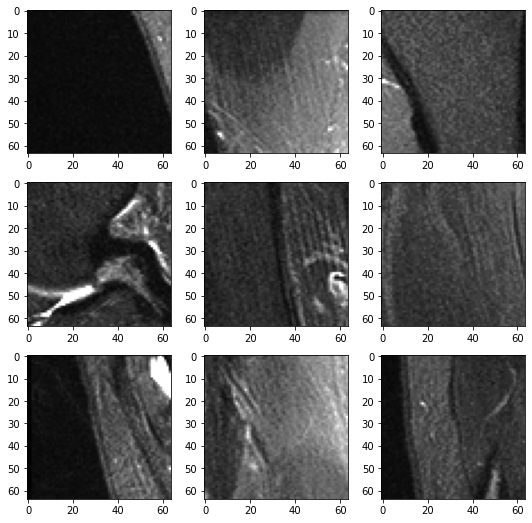

In [ ]:
fig,axs=plt.subplots(3,3,figsize=(9,9))
for i in range(9):
    axs[int(i/3),i%3].imshow((np.transpose(x[4][i])+1)/2.0,cmap='gray')
    #axs[int(i/4),i%4].set_title(str(list(PPP_LABELS.keys())[ppp_labs[i]]))
plt.show()

In [ ]:
x.shape

torch.Size([16, 9, 3, 64, 64])

## Manual Model

In [ ]:
SEED = 16

#### Test Code

In [ ]:
'''rn18 = models.resnet18(pretrained=True)
summary(rn18.to('cuda:0'),(3,224,224))

children_counter = 0
for n,c in rn18.named_children():
    print(n,"Children Counter: ",children_counter)
    if children_counter <= 5:
        for param in c.parameters():
            param.requires_grad = False
    else:
        for param in c.parameters():
            param.requires_grad = True
    #print(n)
    children_counter+=1

rn18._modules'''

'''module_counter = 0
for n,m in rn18.named_modules():
    print("Module Counter: ",module_counter)
    print(n)
    module_counter+=1'''

In [ ]:
'''class dummy_model(nn.Module):
    def __init__(self,model, output_layer):
        super().__init__()
        #self.input_shape = inS
        #self.output_shape = outS
        self.output_layer = output_layer
        self.pretrained = model #models.resnet18(pretrained=True)
        self.layers = list(self.pretrained._modules.keys())
        self.layer_count = 0
        for l in self.layers:
            if l != self.output_layer:
                self.layer_count += 1
            else:
                break
        for i in range(1,len(self.layers)-self.layer_count):
            self.dummy_var = self.pretrained._modules.pop(self.layers[-i])
        
        self.net = nn.Sequential(self.pretrained._modules)
        
        #self.num_trainable_layers = 3
        #self.total_children = 0
        #self.children_list = []
        #for c in self.pretrained.children():
        #    self.total_children += 1
        #print(self.total_children)
        #for n,c in self.pretrained.named_children():
        #    if n != self.output_layer:
        #        self.children_list.append(c)
        #    else:
        #        self.children_list.append(c)
        #        break
        #   #self.children_counter += 1
        
        #self.net = nn.Sequential(*self.children_list)
        self.pretrained = None

    def forward(self,x):
        x = self.net(x)
        return x

model = dummy_model(rn18, 'layer4')
model = model.to('cuda:0')
summary(model,input_size=(3, 224, 224))'''

In [ ]:
#out = model(v1[0,[0]].to('cuda:0').float()).data
'''out = out.cpu()
out = out[0]
#out.shape
#plt.figure()
fig, axs = plt.subplots(16,32,figsize=(200,100))
for i in range(16):
    for j in range(32):
        axs[i,j].imshow(out[i*32+j].data.numpy())'''

### Final Code

In [38]:
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.
        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


class ConvLSTM(nn.Module):

    """
    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.
    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False,return_all_states = False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers
        self.return_all_states = return_all_states

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1]
            last_state_list = last_state_list[-1]
        
        if not self.return_all_states:
            layer_output_list = torch.squeeze(layer_output_list[:,-1,...])

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [39]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape
        #self.batch_size = batch_size

    def forward(self, x):
        #print(list(x.shape),self.shape)
        final_shape = [x.shape[0]//self.shape[0]] + self.shape
        #print(final_shape)
        return x.view(*final_shape)

In [40]:
from torchvision.models.utils import load_state_dict_from_url
from typing import Type, Any, Callable, Union, List, Optional
from torch import Tensor
from collections import OrderedDict 

In [41]:
from torchvision.models.resnet import *
from torchvision.models.resnet import BasicBlock, Bottleneck

In [42]:
class IntResNet(ResNet):
    def __init__(self,output_layer,*args):
        self.output_layer = output_layer
        super().__init__(*args)
        
        self._layers = []
        for l in list(self._modules.keys()):
            self._layers.append(l)
            if l == output_layer:
                break
        self.layers = OrderedDict(zip(self._layers,[getattr(self,l) for l in self._layers]))

    def _forward_impl(self, x):
        for l in self._layers:
            x = self.layers[l](x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

In [43]:
def new_resnet(
    arch: str,
    outlayer: str,
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    pretrained: bool,
    progress: bool,
    **kwargs: Any
) -> IntResNet:

    model_urls = {
        'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
        'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
        'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
        'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
        'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
        'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
        'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
        'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
        'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
    }

    model = IntResNet(outlayer, block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

In [51]:
model = new_resnet('resnet50','layer4',Bottleneck, [3, 4, 6, 3],True,True)
model = model.to('cuda:0')

In [73]:
from torchsummary import summary
summary(m,input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [49]:
class CCLModel(nn.Module):
    def __init__(self,base_model,base_out_layer):
        super().__init__()
        self.base_model = base_model
        self.base_out_layer = base_out_layer
        
        self.model_dict = {'resnet18':{'block':BasicBlock,'layers':[2,2,2,2],'kwargs':{}},
                           'resnet34':{'block':BasicBlock,'layers':[3,4,6,3],'kwargs':{}},
                           'resnet50':{'block':Bottleneck,'layers':[3,4,6,3],'kwargs':{}},
                           'resnet101':{'block':Bottleneck,'layers':[3,4,23,3],'kwargs':{}},
                           'resnet152':{'block':Bottleneck,'layers':[3,8,36,3],'kwargs':{}},
                           'resnext50_32x4d':{'block':Bottleneck,'layers':[3,4,6,3],
                                              'kwargs':{'groups' : 32,'width_per_group' : 4}},
                           'resnext101_32x8d':{'block':Bottleneck,'layers':[3,4,23,3],
                                               'kwargs':{'groups' : 32,'width_per_group' : 8}},
                           'wide_resnet50_2':{'block':Bottleneck,'layers':[3,4,6,3],
                                              'kwargs':{'width_per_group' : 64 * 2}},
                           'wide_resnet101_2':{'block':Bottleneck,'layers':[3,4,23,3],
                                               'kwargs':{'width_per_group' : 64 * 2}}}
        
        #PRETRAINED MODEL
        self.pretrained = new_resnet(self.base_model,self.base_out_layer,
                                     self.model_dict[self.base_model]['block'],
                                     self.model_dict[self.base_model]['layers'],True,True,
                                     **self.model_dict[self.base_model]['kwargs'])
        #self.net2 = models.resnet18(pretrained=True)

        #TAKING OUTPUT FROM AN INTERMEDITATE LAYER
        #PREPRAING THE TRUNCATED MODEL
        self.layers = list(self.pretrained._modules.keys())

        #FREEZING LAYERS
        self.num_trainable_layers = 2
        self.total_children = 0
        self.children_counter = 0
        for c in self.pretrained.children():
            self.total_children += 1
        #print(self.total_children)
        for c in self.pretrained.children():
            if self.children_counter < self.total_children - self.num_trainable_layers:
                for param in c.parameters():
                    param.requires_grad = False
            else:
                for param in c.parameters():
                    param.requires_grad = True
            self.children_counter += 1
        
        self.reshape1 = Reshape([5,2048,7,7])
        self.conv_lstm1 = ConvLSTM(2048,1024,(3,3),1,True,return_all_states = True)
        self.conv_lstm2 = ConvLSTM(1024,512,(3,3),1,True)
        self.relu = nn.ReLU()
        self.avgpool = nn.AdaptiveAvgPool2d((1))
        self.reshape2 = Reshape([2,512])
        self.pred = nn.Linear(2*512,1)
        self.sig = nn.Sigmoid()
        
    def concat(self,x):
        return x.view(x.shape[0],x.shape[1]*x.shape[2])

    def forward(self,x):
        x = self.net(x)
        #print(x.shape)
        x = torch.squeeze(x)
        #print(x.shape)
        x = self.reshape1(x)
        #print(x.shape)
        x,_ = self.conv_lstm1(x)
        x,_ = self.conv_lstm2(x)
        #print(x.shape)
        #x = self.relu(x)
        #print(x.shape)
        x = torch.squeeze(self.avgpool(x))
        #print(x.shape)
        x = self.reshape2(x)
        #print(x.shape)
        x = self.concat(x)
        #print(x.shape)
        x = self.pred(x)
        x = self.sig(x)
        #print(x.shape)
        return x
    

In [50]:
model = CCLModel('resnet50','layer4')
model = model.to('cuda:0')

In [62]:
x = torch.cat((v1.view((-1,3,224,224)),v2.view((-1,3,224,224))), axis = 0)

In [149]:
out = model(x.to('cuda:0').float())

torch.Size([160, 512, 7, 7])
torch.Size([160, 512, 7, 7])
torch.Size([32, 5, 512, 7, 7])
torch.Size([32, 128, 7, 7])
torch.Size([32, 128, 7, 7])
torch.Size([32, 128])
torch.Size([16, 2, 128])
torch.Size([16, 256])
torch.Size([16, 1])


In [ ]:
out.data

### Training

In [134]:
def save_model(epoch,model,optimizer,train_acc,train_loss,valid_acc,valid_loss,model_name,save_path):
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
               'train_loss':train_loss, 'valid_loss':valid_loss,
               'train_accuracy':train_acc,'valid_accuracy':valid_acc}, save_path+'ucf11_newnet_ep'+str(epoch)+'.pt')

In [ ]:
from torch.optim.optimizer import Optimizer, required


class LARS(Optimizer):
    r"""Implements layer-wise adaptive rate scaling for SGD.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): base learning rate (\gamma_0)
        momentum (float, optional): momentum factor (default: 0) ("m")
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
            ("\beta")
        eta (float, optional): LARS coefficient
        max_epoch: maximum training epoch to determine polynomial LR decay.
    Based on Algorithm 1 of the following paper by You, Gitman, and Ginsburg.
    Large Batch Training of Convolutional Networks:
        https://arxiv.org/abs/1708.03888
    Example:
        >>> optimizer = LARS(model.parameters(), lr=0.1, eta=1e-3)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()
    """
    def __init__(self, params, lr=required, momentum=.9,
                 weight_decay=.0005, eta=0.001, max_epoch=200):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}"
                             .format(weight_decay))
        if eta < 0.0:
            raise ValueError("Invalid LARS coefficient value: {}".format(eta))

        self.epoch = 0
        defaults = dict(lr=lr, momentum=momentum,
                        weight_decay=weight_decay,
                        eta=eta, max_epoch=max_epoch)
        super(LARS, self).__init__(params, defaults)

    def step(self, epoch=None, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
            epoch: current epoch to calculate polynomial LR decay schedule.
                   if None, uses self.epoch and increments it.
        """
        loss = None
        if closure is not None:
            loss = closure()

        if epoch is None:
            epoch = self.epoch
            self.epoch += 1

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            eta = group['eta']
            lr = group['lr']
            max_epoch = group['max_epoch']

            for p in group['params']:
                if p.grad is None:
                    continue

                param_state = self.state[p]
                d_p = p.grad.data

                weight_norm = torch.norm(p.data)
                grad_norm = torch.norm(d_p)

                # Global LR computed on polynomial decay schedule
                decay = (1 - float(epoch) / max_epoch) ** 2
                global_lr = lr * decay

                # Compute local learning rate for this layer
                local_lr = eta * weight_norm / \
                    (grad_norm + weight_decay * weight_norm)

                # Update the momentum term
                actual_lr = local_lr * global_lr

                if 'momentum_buffer' not in param_state:
                    buf = param_state['momentum_buffer'] = \
                            torch.zeros_like(p.data)
                else:
                    buf = param_state['momentum_buffer']
                buf.mul_(momentum).add_(actual_lr, d_p + weight_decay * p.data)
                p.data.add_(-buf)

        return loss

In [160]:
loss_fn = nn.BCELoss()

optimizer = torch.optim.RMSprop([params for params in model.parameters() if params.requires_grad],lr=0.01)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=1,gamma=0.95,last_epoch=-1)

cos = nn.CosineSimilarity(dim = 1)

In [161]:
def print_metrics(metrics):
    cols=['Training','Validation']
    metricskeys = list(metrics.keys())
    table = [[mk]+metrics[mk] for mk in metricskeys]
    table = tabulate(table,headers=cols,tablefmt='grid')
    print(table)

In [162]:
def get_accuracy(y_true, y_prob):
    #assert y_true.ndim == 1 and y_true.size() == y_prob.size()
    y_prob = y_prob > 0.5
    return (y_true == y_prob).sum().item() / y_true.size(0)

In [163]:
# without lambda
def contrastive_loss(y_true, sim_scores, tau = 0.07):
    loss = 0
    #sim_scores = cos(sim_scores[:,0,:],sim_scores[:,1,:])/tau
    num1 = torch.exp(y_true*sim_scores) #torch.sum(y_true*sim_scores))
    num2 = torch.exp((1-y_true)*sim_scores)
    den = torch.sum(torch.exp(sim_scores)) #torch.cat((sim_scores[[0]],1-sim_scores[1:]),dim = 0)))
    h = torch.sum(y_true*torch.log(num1/den)) #- torch.sum(torch.log(num2/den))
    loss -= h
    g = torch.sum((1-y_true)*torch.log(1 - (num2/den)))
    loss -= g
    return loss

In [164]:
num_patience = 4
batch_size = 16
hnb_pred_vals = np.zeros((128,num_patience))
columns = ['sample_path1','sample_path2',
           'start_index1','start_index2',
           'shuffle_order1','shuffle_order2',
           'transforms1','transforms2',
           'similarity_score']

In [170]:
hnb = neg_bank(64)
snb = neg_bank(64)
HNB_CAPACITY = 64
SNB_CAPACITY = 64

In [171]:
dg = TOVDataGen('train',sg_tr_filenames_df, batch_size = 32, new_size = 16, hard_neg_bank = hnb)
hnbgen = NBDataGen('train',sg_tr_filenames_df,batch_size = 16, neg_bank = hnb)
snbgen = NBDataGen('train',sg_tr_filenames_df,batch_size = 16, neg_bank = snb)

dl = DataLoader(dg,batch_size = 32)
hnbl = DataLoader(hnbgen, batch_size = 32)
snbl = DataLoader(snbgen, batch_size = 32)

In [172]:
vdg = TOVDataGen('valid',sg_val_filenames_df, batch_size = 16, new_size = 16, hard_neg_bank = None)
vdl = DataLoader(vdg,batch_size = 16)

In [ ]:
for epoch in range(5):
    stime = time.time()
    print("=============== Epoch : %3d ==============="%(epoch+1))
    loss_sublist = []
    acc_sublist = []
    yhats = 0
    correct = 0
    #model.train()
    #z = torch.Tensor([]).view(0,1).to(device='cuda:0',dtype=torch.float)
    COUNT = 10
    for [v1,v2],s,sp1,sp2,sf1,sf2,so1,so2,t1,t2 in dl:
        model.train()
        print('<----------CURRENT BATCH UNDER PROCESS------------->')
        x = torch.cat((v1.view((-1,3,224,224)),v2.view((-1,3,224,224))), dim = 0)
        x,y = x.to(device = 'cuda:0', dtype = torch.float),s.to(device = 'cuda:0')
        
        optimizer.zero_grad()
        
        z = model(x)

        #------------------------------------------------------------------------------------------------------
        print('<---------HARD NEGATIVE BANK UNDER PROCESS--------->')
        #PASS THE SAMPLS IN HNB AS INPUT
        for [hv1,hv2],hs,hsp1,hsp2,hsf1,hsf2,hso1,hso2,ht1,ht2 in hnbl:

            hx = torch.cat((hv1.view((-1,3,224,224)),hv2.view((-1,3,224,224))), dim = 0)

            #hnbx = torch.cat((hnbx,hx.view((1,-1,3,224,224))),dim = 0)

            hx,y = hx.to(device = 'cuda:0', dtype = torch.float),torch.cat((y, hs.to(device = 'cuda:0')),dim = 0)

            z = torch.cat((z, model(hx)), dim = 0)


        sim_scores = z.data.cpu()
        #print("Similarity Scores : ",sim_scores)
        #------------------------------------------------------------------------------------------------------
        #back propagation
        print('<---------------BACK PROPAGATION------------------->')
        tr_loss = contrastive_loss(y.to(dtype=torch.float), z)
        print('CONTRASTIVE LOSS: ',tr_loss.data.item())
        tr_loss.backward()
        optimizer.step()
        loss_sublist.append(tr_loss.data.item())

        #-------------------------------------------------------------------------------------------------------
    
        model.eval()
        
        print('<----UPDATING HNB SIMILARITY SCORES AND ORDER------>')
        #UPDATE THE HNB SIMILARITY SCORES FIRST
        hnbpreds = np.array([]).reshape((0,1))
        if hnb.__len__()>0:
            for [hv1,hv2],hs,hsp1,hsp2,hsf1,hsf2,hso1,hso2,ht1,ht2 in hnbl:
                hx = torch.cat((hv1.view((-1,3,224,224)),hv2.view((-1,3,224,224))), dim = 0).to(device = 'cuda:0', dtype = torch.float)
                hnbpreds = np.append(hnbpreds,model(hx).cpu().data.numpy().reshape((-1,1)),axis = 0)
        #insert the updated similarity scores
        if hnbpreds.shape[0]!=0:
            hnb.bank['similarity_score'] = hnbpreds.flatten()
            #Sort on the basis of the similarity scores
            hnb.sort()
        
        #PREDICT THE VALUES OF BATCH SAMPLES
        print('<------CALCULATING UPDATED PREDICTION VALUES---->')
        z = model(x)
        #print(z.shape)
        preds = z.cpu().data.numpy().reshape((-1,1))
        
        if hnbpreds.shape[0]!=0:
            preds = np.append(preds,hnbpreds,axis=0)
        preds2 = np.array(preds>=0.5).astype(int)
        print(preds2.shape)
        accuracy = np.sum(preds2==y.cpu().data.numpy())/preds.shape[0]
        
        print("Accuracy: ",accuracy)
        print("AUC: ",roc_auc_score(y.cpu().data,preds))
        
        # ADD SAMPLES TO HNB
        print('<---------ADDING NEW SAMPLES TO HNB------------>')

        #append all new ng to hnb

        #UNCOLLATING SOME VARIABLES
        so1 = torch.cat([so.view(-1,1) for so in so1], dim = 1)
        so2 = torch.cat([so.view(-1,1) for so in so2], dim = 1)

        augs = list(t1.keys())
        t1['ColorJitter'] = torch.cat([t_.view(-1,1).data for t_ in t1['ColorJitter']], dim = 1).numpy()
        t1['RandomCrop'] = torch.cat([t_.view(-1,1).data for t_ in t1['RandomCrop']], dim = 1).numpy()
        t1['RandomRotation'] = t1['RandomRotation'].numpy()
        t1['GaussianBlur'] = t1['GaussianBlur'].numpy()
        t1['HorizontalFlip'] = t1['HorizontalFlip'].numpy()
        ldt1 = []
        lent = t1['HorizontalFlip'].shape[0]
        for i in range(lent):
            ldt1.append(dict(zip(augs,[t1[aug][i] for aug in augs])))

        t2['ColorJitter'] = torch.cat([t_.view(-1,1).data for t_ in t2['ColorJitter']], dim = 1).numpy()
        t2['RandomCrop'] = torch.cat([t_.view(-1,1).data for t_ in t2['RandomCrop']], dim = 1).numpy()
        t2['RandomRotation'] = t2['RandomRotation'].numpy()
        t2['GaussianBlur'] = t2['GaussianBlur'].numpy()
        t2['HorizontalFlip'] = t2['HorizontalFlip'].numpy()
        ldt2 = []
        lent = t2['HorizontalFlip'].shape[0]
        for i in range(lent):
            ldt2.append(dict(zip(augs,[t2[aug][i] for aug in augs])))

        for idx in range(8,lent):
            if s[idx] == 0:
                creds = [sp1[idx],sp2[idx],
                         sf1[idx].data.numpy(),sf2[idx].data.numpy(),
                         so1[idx].data.numpy(),so2[idx].data.numpy(),
                         ldt1[idx],ldt2[idx],sim_scores[idx].numpy()]
                #print(creds)
                if hnb.__len__() < HNB_CAPACITY:
                    hnb.add_to_bank(dict(zip(columns,creds)))
                    #sort according to the pred values
                    hnb.sort()
                else:
                    #check if any hnp in hnb has become soft. (Check the last 4-5 prediction values)
                    if preds[idx] > hnb.bank['similarity_score'][HNB_CAPACITY - 1]:
                        #move them to snb
                        if snb.__len__() < SNB_CAPACITY:
                            snb.add_to_bank(dict(zip(columns,hnb.bank.iloc[HNB_CAPACITY - 1].values)))
                            snb.sort()
                        else:
                            if hnb.bank['similarity_score'][HNB_CAPACITY - 1] > snb.bank['similarity_score'][SNB_CAPACITY - 1]:
                                snb.bank.iloc[SNB_CAPACITY - 1] = np.array(hnb.bank.iloc[HNB_CAPACITY - 1].values,dtype = object)
                                snb.sort()
                        #add new ngs to hnb. fill void
                        hnb.bank.iloc[HNB_CAPACITY - 1] = np.array(creds,dtype=object)
                        hnb.sort()
                    else:
                        if snb.__len__() < SNB_CAPACITY:
                            snb.add_to_bank(dict(zip(columns,creds)))
                            snb.sort()
                        else:
                            if creds[-1] > snb.bank['similarity_score'][SNB_CAPACITY - 1]:
                                snb.bank.iloc[SNB_CAPACITY - 1] = np.array(creds,dtype=object)
                                snb.sort()

    # CHECK IF SOME SOFT PAIRS HAVE BECOME HARD
    print('<----------CHECKING SNB FOR HARDER PAIRS----------->')
    snbpreds = np.array([]).reshape((0,1))
    if snb.__len__()>0:
        for [sv1,sv2],ss,ssp1,ssp2,ssf1,ssf2,sso1,sso2,st1,st2 in snbl:
            sx = torch.cat((sv1.view((-1,3,224,224)),sv2.view((-1,3,224,224))), dim = 0).to(device = 'cuda:0', dtype = torch.float)
            snbpreds = np.append(snbpreds,model(sx).cpu().data.numpy().reshape((-1,1)),axis = 0)
    #insert the updated similarity scores
    if snbpreds.shape[0]!=0:
        snb.bank['similarity_score'] = snbpreds.flatten()
        #Sort on the basis of the similarity scores
        snb.sort()
    print('<------REPLACING HARDER PAIRS OF SNB IN HNB-------->')
    #REPLACING THE HARDER PAIRS OF SNB IN HNB
    for i in range(snb.__len__()):
        if snb.bank['similarity_score'][i] < hnb.bank['similarity_score'][HNB_CAPACITY - 1]:
            break
        else:
            temp_val = np.array(hnb.bank.iloc[HNB_CAPACITY - 1].values,dtype = object)
            hnb.bank.iloc[HNB_CAPACITY - 1] = np.array(snb.bank.iloc[i].values,dtype=object)
            snb.bank.iloc[i] = temp_val
            hnb.sort()
            snb.sort()


    '''accuracy=correct/(16*N_train)
    #print(len(yhats))
    train_acc.append(accuracy)    
    train_loss.append(np.mean(loss_sublist))
    
    loss_sublist = []
    acc_sublist = []
    correct = 0'''
    model.eval()
    y_true = torch.Tensor([]).view(0,1)
    y_pred = torch.Tensor([]).view(0,1)
    for [v1,v2],s,_,_,_,_,_,_,_,_ in vdl:
        x = torch.cat((v1.view((-1,3,224,224)),v2.view((-1,3,224,224))), dim = 0)
        x,y = x.to(device = 'cuda:0', dtype = torch.float),s.to(device = 'cuda:0')
        y_true = torch.cat((y_true,s),dim = 0)
        z = model(x)
        preds = z.cpu().data.view(-1,1)
        y_pred = torch.cat((y_pred,preds),dim=0)
        preds2 = np.array(preds>=0.5).astype(int)

        val_loss = contrastive_loss(y.to(dtype = torch.float),z)
        loss_sublist.append(val_loss.data.item())

        #_,yhat = torch.max(z.data,1)
        correct +=np.sum(preds2==y.cpu().data.numpy())
    val_acc=correct/120

    '''valid_acc.append(accuracy)    
    valid_loss.append(np.mean(loss_sublist))'''

    print(f'Validation Accuracy:{val_acc}, Validation Loss: {np.mean(loss_sublist)}, Validaiton AUC: {roc_auc_score(y_true.data, y_pred.data)}')

    lr_scheduler.step()

    '''print_metrics({'Accuracy':[train_acc[-1],valid_acc[-1]],'Loss':[train_loss[-1],valid_loss[-1]]})
    print("Time taken for Epoch %3d : %.3f minutes"%(epoch+1,(time.time()-stime)/60))
    print("Saving Model...")
    save_model(epoch+1, model, optimizer, train_acc, train_loss, valid_acc, valid_loss,'UCFNewNet',save_model_PATH)'''

=============== Epoch :   1 ===============
<----------CURRENT BATCH UNDER PROCESS------------->
<---------HARD NEGATIVE BANK UNDER PROCESS--------->
<---------------BACK PROPAGATION------------------->
CONTRASTIVE LOSS:  37.7263069152832
<----UPDATING HNB SIMILARITY SCORES AND ORDER------>
<------CALCULATING UPDATED PREDICTION VALUES---->
(96, 1)
Accuracy:  0.9166666666666666
AUC:  0.23011363636363635
<---------ADDING NEW SAMPLES TO HNB------------>
<----------CURRENT BATCH UNDER PROCESS------------->
<---------HARD NEGATIVE BANK UNDER PROCESS--------->
<---------------BACK PROPAGATION------------------->
CONTRASTIVE LOSS:  37.42168426513672
<----UPDATING HNB SIMILARITY SCORES AND ORDER------>
<------CALCULATING UPDATED PREDICTION VALUES---->
(96, 1)
Accuracy:  0.9166666666666666
AUC:  0.25852272727272724
<---------ADDING NEW SAMPLES TO HNB------------>
<----------CURRENT BATCH UNDER PROCESS------------->
<---------HARD NEGATIVE BANK UNDER PROCESS--------->
<---------------BACK PROPAG

In [184]:
lr_scheduler.step()

In [183]:
print(f'Validation Accuracy:{val_acc}, Validation Loss: {np.mean(loss_sublist)}, Validaiton AUC: {roc_auc_score(y_true.data, y_pred.data)}')

Validation Accuracy:0.9333333333333333, Validation Loss: 32.28796041928805, Validaiton AUC: 0.52734375


In [174]:
y.cpu().data

tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])

In [169]:
hnb.bank

,sample_path1,sample_path2,start_index1,start_index2,shuffle_order1,shuffle_order2,transforms1,transforms2,similarity_score
0,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...,14,14,"[4, 2, 0, 1, 3]","[4, 0, 2, 1, 3]","{'RandomRotation': 0.0, 'RandomCrop': [256, 25...","{'RandomRotation': 0.0, 'RandomCrop': [256, 25...",0.997836
1,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...,58,58,"[4, 1, 2, 0, 3]","[4, 3, 2, 0, 1]","{'GaussianBlur': 1.0674189329147339, 'ColorJit...","{'GaussianBlur': 0.0, 'ColorJitter': [0.0, 0.0...",0.997835
2,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...,29,29,"[2, 0, 3, 1, 4]","[1, 0, 3, 2, 4]","{'HorizontalFlip': False, 'RandomRotation': -2...","{'HorizontalFlip': False, 'RandomRotation': 0....",0.997834
3,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...,26,26,"[2, 0, 3, 4, 1]","[3, 0, 2, 4, 1]","{'ColorJitter': [0.9688492924728476, 1.1878808...","{'ColorJitter': [0.7908863962716991, 0.9806215...",0.997833
4,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...,31,31,"[2, 0, 3, 4, 1]","[4, 0, 3, 2, 1]","{'RandomRotation': -29.25664520263672, 'Random...","{'RandomRotation': 0.0, 'RandomCrop': [256, 25...",0.997784
5,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...,87,87,"[0, 3, 4, 1, 2]","[0, 4, 3, 1, 2]","{'HorizontalFlip': False, 'RandomRotation': 0....","{'HorizontalFlip': True, 'RandomRotation': -21...",0.997735
6,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...,7,7,"[2, 4, 3, 1, 0]","[2, 4, 3, 0, 1]","{'GaussianBlur': 1.8160978555679321, 'RandomRo...","{'GaussianBlur': 0.6737161874771118, 'RandomRo...",0.997638
7,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...,37,37,"[1, 3, 2, 0, 4]","[1, 2, 3, 0, 4]","{'RandomRotation': 0.0, 'GaussianBlur': 1.1122...","{'RandomRotation': -28.47309684753418, 'Gaussi...",0.997554
8,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...,38,38,"[1, 2, 4, 0, 3]","[1, 2, 3, 0, 4]","{'GaussianBlur': 0.0, 'ColorJitter': [0.946284...","{'GaussianBlur': 0.0, 'ColorJitter': [0.813003...",0.997552
9,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...,/mnt/disks/data/GCP/Stanford MRNet-v1/MRNet-v1...,51,51,"[4, 1, 2, 0, 3]","[2, 1, 4, 0, 3]","{'ColorJitter': [1.1369633045523728, 1.1629509...","{'ColorJitter': [0.9146702643820827, 0.9480184...",0.997549


In [55]:
snb.bank.iloc[1] = np.array(creds,dtype=object)

### CVPR Model

In [ ]:
def conv3x3(inC,outC,stride=1,padding=1):
    return nn.Conv2d(inC,outC,kernel_size=3,stride = stride, padding = padding)

def conv1x1(inC,outC,stride=1,padding=1):
    return nn.Conv2d(inC,outC,kernel_size=1,stride = stride, padding = padding)

def norm_layer(inC):
    return nn.BatchNorm2d(inC)

def maxpool(kernel_size = 2, stride = 2):
    return nn.MaxPool2d(kernel_size = kernel_size, stride = stride)

def avgpool(kernel_size = 2, stride = 2):
    return nn.AvgPool2d(kernel_size = kernel_size, stride = stride)

class Conv_block(nn.Module):
    def __init__(self,inC,outC,upsample = 1,**kwargs):
        super(Conv_block,self).__init__()
        self.inC = inC
        self.outC = outC
        self.upsample = upsample
        self.outC1 = self.outC // upsample
        self.outC2 = self.outC
        
        self.conv1 = conv3x3(self.inC,self.outC1)
        self.bn1 = norm_layer(self.outC1)
        self.conv2 = conv3x3(self.outC1,self.outC1)
        self.bn2 = norm_layer(self.outC1)
        self.conv3 = conv3x3(self.outC1,self.outC2)
        self.bn3 = norm_layer(self.outC2)
        self.conv4 = conv3x3(self.outC2,self.outC2)
        self.bn4 = norm_layer(self.outC2)
        self.relu = nn.ReLU(inplace = True)
        self.downsample = maxpool()
        
    def forward(self,x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.downsample(out)
        #print(out.shape)
        
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu(out)
        
        out = self.conv4(out)
        out = self.bn4(out)
        out = self.relu(out)
        
        out = self.downsample(out)
        #print(out.shape)
        
        return out
    
class Skip_block(nn.Module):
    def __init__(self,inC,outC,upsample = 2,**kwargs):
        super(Skip_block, self).__init__()
        self.inC = inC
        self.outC = outC
        self.upsample = upsample
        try:
            self.scale  = kwargs['scale']
        except:
            self.scale = 1.0
        
        self.outC1 = self.outC//self.upsample
        self.outC2 = self.outC
        
        self.conv1 = conv3x3(self.inC,self.outC1)
        self.bn1 = norm_layer(self.outC1)
        self.conv2 = conv3x3(self.outC1, self.outC2)
        self.bn2 = norm_layer(self.outC2)
        self.relu = nn.ReLU(inplace = True)
        
    def forward(self,x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        #print("SKIP::",out.shape)
        out = self.scale*out + identity
        
        return out

class Dim_Red_block(nn.Module):
    def __init__(self,inC,outC,upsample = 1,**kwargs):
        super(Dim_Red_block,self).__init__()
        self.inC= inC
        self.upsample = upsample
        self.outC = outC
        
        self.outC1 = (self.outC//2)//self.upsample
        self.outC2 = self.outC//2
        
        try:
            self.downfactor = kwargs['downfactor']
        except:
            self.downfactor = 2
            
        if self.downfactor == 2:
            self.stride1 = 1
        elif self.downfactor == 4:
            self.stride1 = 2
        self.stride2 = 2
        
        self.conv11 = conv3x3(self.inC, self.outC1, stride = self.stride1)
        self.bn11 = norm_layer(self.outC1)
        self.conv12 = conv3x3(self.outC1, self.outC2, stride = self.stride2)
        self.bn12 = norm_layer(self.outC2)
        
        self.downsample21 = avgpool()
        self.conv22 = conv1x1(self.inC,self.outC2,padding = 0)
        self.bn22 = norm_layer(2*self.outC2)
        self.relu = nn.ReLU(inplace = True)
        
    def forward(self,x):
        out1 = self.conv11(x)
        out1 = self.bn11(out1)
        out1 = self.relu(out1)
        #print("DIMRED:",out1.shape)
        out1 = self.conv12(out1)
        '''out1 = self.bn12(out1)
        out1 = self.relu(out1)''' #new change
        #print(out1.shape)
        
        out2 = self.downsample21(x)
        out2 = self.conv22(out2)
        #new hcnage
        #print(out2.shape)
        
        out = torch.cat((out1,out2),dim=1)
        out = self.bn22(out)
        out = self.relu(out) # new change
        return out
    
class JPOP_net(nn.Module): 
    def __init__(self,conv_block,skip_block,dim_red_block, layer_outs, upsampling_dict, 
                 downfactor = 2, scale = 1.0, input_shape = (3,64,64), num_classes = 500):
        super(JPOP_net,self).__init__()
        self.conv_block = conv_block
        self.skip_block = skip_block
        self.dim_red_block = dim_red_block
        self.input_shape = input_shape
        self.inC = self.input_shape[0]
        self.num_classes = num_classes
        self.up_dict = upsampling_dict
        self.downfactor = downfactor
        self.scale = scale
        
        self.conv_channel1 = self._make_layer(self.conv_block,self.inC,layer_outs[0],self.up_dict['conv_block'])
        self.conv_channel2 = self._make_layer(self.conv_block,self.inC,layer_outs[0],self.up_dict['conv_block'])
        self.conv_channel3 = self._make_layer(self.conv_block,self.inC,layer_outs[0],self.up_dict['conv_block'])
        self.conv_channel4 = self._make_layer(self.conv_block,self.inC,layer_outs[0],self.up_dict['conv_block'])
        self.conv_channel5 = self._make_layer(self.conv_block,self.inC,layer_outs[0],self.up_dict['conv_block'])
        self.conv_channel6 = self._make_layer(self.conv_block,self.inC,layer_outs[0],self.up_dict['conv_block'])
        self.conv_channel7 = self._make_layer(self.conv_block,self.inC,layer_outs[0],self.up_dict['conv_block'])
        self.conv_channel8 = self._make_layer(self.conv_block,self.inC,layer_outs[0],self.up_dict['conv_block'])
        self.conv_channel9 = self._make_layer(self.conv_block,self.inC,layer_outs[0],self.up_dict['conv_block'])
        
        self.conv1x1layer = conv1x1(9*layer_outs[0],layer_outs[1],padding=0)
        self.bn1x1 = norm_layer(layer_outs[1])
        self.relu = nn.ReLU(inplace=True)
        
        self.skip_block1 = self._make_layer(self.skip_block,layer_outs[1],
                                            layer_outs[2],upsample = self.up_dict['skip1'],
                                            scale = self.scale)
        
        self.dim_red_block1 = self._make_layer(self.dim_red_block,layer_outs[2],
                                               layer_outs[3], upsample = self.up_dict['dimred1'],
                                               downfactor = self.downfactor)
        
        self.skip_block2 = self._make_layer(self.skip_block,layer_outs[3],
                                            layer_outs[4],upsample = self.up_dict['skip2'],
                                            scale = self.scale)
        
        self.dim_red_block2 = self._make_layer(self.dim_red_block,layer_outs[4],
                                               layer_outs[5],upsample = self.up_dict['dimred2'],
                                               downfactor = self.downfactor)
        
        self.globalavgpool = avgpool(kernel_size = 4, stride = 4)
        
        self.fc1 = nn.Linear(layer_outs[5],1024)
        self.fc2 = nn.Linear(1024,1024)
        
        self.output = nn.Linear(1024,self.num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    
    def _make_layer(self,block,inC,outC,upsample,**kwargs):
        layers = [block(inC,outC,upsample,**kwargs)]
        return nn.Sequential(*layers)
    
    def _forward_impl(self,x):
        #print(x.shape,x.select(1,0).shape)
        out1 = self.conv_channel1(x.select(1,0)) #.to(memory_format=torch.channels_last))
        out2 = self.conv_channel2(x.select(1,1)) #.to(memory_format=torch.channels_last))
        out3 = self.conv_channel3(x.select(1,2)) #.to(memory_format=torch.channels_last))
        out4 = self.conv_channel4(x.select(1,3)) #.to(memory_format=torch.channels_last))
        out5 = self.conv_channel5(x.select(1,4)) #.to(memory_format=torch.channels_last))
        out6 = self.conv_channel6(x.select(1,5)) #.to(memory_format=torch.channels_last))
        out7 = self.conv_channel7(x.select(1,6)) #.to(memory_format=torch.channels_last))
        out8 = self.conv_channel8(x.select(1,7)) #.to(memory_format=torch.channels_last))
        out9 = self.conv_channel9(x.select(1,8)) #.to(memory_format=torch.channels_last))
        
        out = torch.cat((out1,out2,out3,out4,out5,out6,out7,out8,out9),dim = 1)
        #print(out.shape)
        out = self.conv1x1layer(out)
        out = self.bn1x1(out)
        out = self.relu(out)
        #print(out.shape)
        out = self.skip_block1(out)
        #print(out.shape)
        out = self.dim_red_block1(out)
        out = self.skip_block2(out)
        out = self.dim_red_block2(out)
        
        out = self.globalavgpool(out)
        #print(out.shape)
        out = torch.flatten(out,1)
        #print(out.shape)
        out = self.fc1(out)
        out = self.relu(out)
        #print(out.shape)
        out = self.fc2(out)
        out = self.relu(out)
        #print(out.shape)
        out = self.output(out)
        
        return out
    
    def forward(self,x):
        return self._forward_impl(x)
    
def model(conv_block,skip_block,dim_red_block,layer_outs,upsampling_dict,
          input_shape = (3,64,64),num_classes = 500,scale = 1.0,downfactor = 2):
    
    return JPOP_net(conv_block,skip_block,dim_red_block,layer_outs,upsampling_dict,
                    downfactor = 2, scale = 1.0, input_shape = (3,64,64), num_classes = 500)

### Over sampling

In [ ]:
NUM_1 = np.count_nonzero(tr_multilabel['acl']==1)
NUM_0 = np.count_nonzero(tr_multilabel['acl']==0)
min_class = np.argmin(np.array([NUM_0,NUM_1]))
if int(min_class) == 0:
    gapnum = (1130-NUM_0)-NUM_0
    INDICES = tr_multilabel[tr_multilabel['acl']==0].index.values
    INDICES = np.random.choice(list(INDICES),gapnum)
else:
    gapnum = (1130-NUM_1)-NUM_1
    INDICES = tr_multilabel[tr_multilabel['acl']==1].index.values
    INDICES = np.random.choice(list(INDICES),gapnum)
    
tr_acl_multilabel = tr_multilabel.append(tr_multilabel.iloc[INDICES,:],ignore_index=True)
tr_acl_filenames_df = tr_filenames_df.append(tr_filenames_df.iloc[INDICES,:],ignore_index=True)

idx = np.random.permutation(tr_acl_filenames_df.index.values)
tr_acl_multilabel = tr_acl_multilabel.reindex(idx)
tr_acl_filenames_df = tr_acl_filenames_df.reindex(idx)
tr_acl_multilabel = tr_acl_multilabel.reset_index(drop=True)
tr_acl_filenames_df = tr_acl_filenames_df.reset_index(drop=True)

print(tr_acl_multilabel)
print(tr_acl_filenames_df)

In [ ]:
tdg = PPPDataGen('train','sagittal',mrnet_path,tr_acl_filenames_df,preprocess_input = ppi_irv2,ppp_labels_dict = PPP_LABELS,gtp_labels_dict = GTP_LABELS,batch_size=32,num_frames=1,num_classes=NUM_CLASSES,hor_flip=False,data_aug=True)

In [ ]:
vdg = PPPDataGen('valid','sagittal',mrnet_path,val_filenames_df,preprocess_input = ppi_irv2,ppp_labels_dict = PPP_LABELS,gtp_labels_dict = GTP_LABELS,batch_size=32,num_frames=1,num_classes=NUM_CLASSES,hor_flip=False,data_aug=True)

## Manual Training Loop

In [ ]:
SEED = 16

In [ ]:
!nvidia-smi

Thu Sep  3 05:19:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
upsampling_dict = {'conv_block':1,'skip1':2,'dimred1':1,'skip2':2,'dimred2':1}
sag_rocket_model = model(Conv_block,Skip_block,Dim_Red_block,[256,1024,1024,2048,2048,4096],
                         upsampling_dict, downfactor = 2, scale = 1.0, input_shape = (3,64,64), num_classes = 500)
device = torch.device("cuda")
sag_rocket_model.to(device)

JPOP_net(
  (conv_channel1): Sequential(
    (0): Conv_block(
      (conv1): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv_channel2): Sequential(
    (0): Conv_block(
      (conv1): Conv2d(3, 256, kernel_size=

In [ ]:
summary(sag_rocket_model,(9,3,64,64))

In [ ]:
'''x = torch.zeros((1,9,3,64,64),dtype=torch.float,requires_grad=False)
x = x.to(torch.device('cuda:0'))
#x = x.to(memory_format = torch.channels_last)
out = sag_rocket_model(x)'''

In [ ]:
'''dotobj = make_dot(out)
print(dotobj)'''

### Manual Training

In [ ]:
MAXLR = 0.0001
def LRscheduler(epoch,lr):
    global MAXLR
    
    lr = 0.95*lr
    
    epochrem = epoch%50
    if epochrem==0 and epoch > 1:
        MAXLR *= 0.25
        lr = MAXLR
        
    if lr < 5*10**(-6):
        lr = 0.000005

    return lr

In [ ]:
tdg = PPPDataGen('train','sagittal',mrnet_path,tr_filenames_df,preprocess_input = ppi_irv2,ppp_labels_dict = PPP_LABELS,gtp_labels_dict = GTP_LABELS,batch_size=1,num_frames = 1,num_classes=NUM_CLASSES,hor_flip = False,data_aug = True)
vdg = PPPDataGen('valid','sagittal',mrnet_path,val_filenames_df,preprocess_input = ppi_irv2,ppp_labels_dict = PPP_LABELS,gtp_labels_dict = GTP_LABELS,batch_size=1,num_frames = 1,num_classes=NUM_CLASSES,hor_flip = False,data_aug = False)
tdl = DataLoader(tdg,batch_size=16)
vdl = DataLoader(vdg,batch_size=16)

In [ ]:
total = 0
for x,y in tdl:
    total += x.shape[0]
print(total)

18080


In [ ]:
os.makedirs('/content/saved_models/')

In [ ]:
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []
n_epochs = 20
N_train = len(tdl)
N_valid = len(vdl)
save_model_PATH = '/content/saved_models/'

In [ ]:
len(vdl)

120

In [ ]:
def save_model(epoch,model,optimizer,train_acc,train_loss,valid_acc,valid_loss,model_name,save_path):
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
               'train_loss':train_loss, 'valid_loss':valid_loss,
               'train_accuracy':train_acc,'valid_accuracy':valid_acc}, save_path+'sagittal_JPOPnet_ep'+str(epoch)+'.pt')

In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam([params for params in sag_rocket_model.parameters() if params.requires_grad],lr=0.0001)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=1,gamma=0.95,last_epoch=-1)

In [ ]:
def print_metrics(metrics):
    cols=['Training','Validation']
    metricskeys = list(metrics.keys())
    table = [[mk]+metrics[mk] for mk in metricskeys]
    table = tabulate(table,headers=cols,tablefmt='grid')
    print(table)

In [ ]:
for epoch in range(10,20):
    stime = time.time()
    print("============= Epoch : %3d ============="%(epoch+1))
    loss_sublist = []
    acc_sublist = []
    yhats = 0
    correct = 0
    #sag_rocket_model.train()
    for x,y in tdl:
        sag_rocket_model.train()
        x,y = x.to(device = device, dtype = torch.float),y.to(device = device)
        optimizer.zero_grad()
        z = sag_rocket_model(x)
        #print(z.shape)
        tr_loss = loss_fn(z,y)
        tr_loss.backward()
        optimizer.step()
        loss_sublist.append(tr_loss.data.item())
        
        sag_rocket_model.eval()
        z = sag_rocket_model(x)
        _,yhat = torch.max(z.data,1)
        #yhats+=len(yhat)
        correct +=(yhat==y).sum().item()
    accuracy=correct/(16*N_train)
    #print(len(yhats))
    train_acc.append(accuracy)    
    train_loss.append(np.mean(loss_sublist))
    
    loss_sublist = []
    acc_sublist = []
    correct = 0
    sag_rocket_model.eval()
    for x,y in vdl:
        x,y = x.to(device = device, dtype = torch.float),y.to(device = device)
        z = sag_rocket_model(x)
        val_loss = loss_fn(z,y)
        loss_sublist.append(val_loss.data.item())
        
        _,yhat = torch.max(z.data,1)
        correct +=(yhat==y).sum().item()
    accuracy=correct/(16*N_valid)
        
    valid_acc.append(accuracy)    
    valid_loss.append(np.mean(loss_sublist))
    
    lr_scheduler.step()

    print_metrics({'Accuracy':[train_acc[-1],valid_acc[-1]],'Loss':[train_loss[-1],valid_loss[-1]]})
    print("Time taken for Epoch %3d : %.3f minutes"%(epoch+1,(time.time()-stime)/60))
    print("Saving Model...")
    save_model(epoch+1,sag_rocket_model,optimizer,train_acc,train_loss,valid_acc,valid_loss,'Sagittal_JPOP_Net',save_model_PATH)

============= Epoch :  11 =============
+----------+------------+--------------+
|          |   Training |   Validation |
+==========+============+==============+
| Accuracy |   0.727876 |     0.773438 |
+----------+------------+--------------+
| Loss     |   1.32269  |     0.844312 |
+----------+------------+--------------+
Time taken for Epoch  11 : 25.836 minutes
Saving Model...
============= Epoch :  12 =============
+----------+------------+--------------+
|          |   Training |   Validation |
+==========+============+==============+
| Accuracy |   0.741925 |     0.773438 |
+----------+------------+--------------+
| Loss     |   1.27306  |     0.818229 |
+----------+------------+--------------+
Time taken for Epoch  12 : 25.793 minutes
Saving Model...
============= Epoch :  13 =============
+----------+------------+--------------+
|          |   Training |   Validation |
+==========+============+==============+
| Accuracy |   0.747069 |     0.794792 |
+----------+------------+-

In [ ]:
yhats

18080

In [ ]:
16*1130

18080

In [ ]:
yhat[0].size.data

AttributeError: ignored

## Perf Metrics

In [ ]:
y = np.array([]).reshape((0,500))
y_true = np.array([])
pred = np.array([]).reshape((0,500))
for i in range(10000):
    jpp_inputs,jpp_out_true = vdg.__getitem__(i)
    y_true = np.append(y_true,jpp_out_true)
    y = np.append(y,to_categorical(jpp_out_true.astype('int'),num_classes=500),axis=0)
    jpp_pred = sag_rocket_model(jpp_inputs)
    pred = np.append(pred,jpp_pred,axis=0)

class_labels = ['abnormality','acl tear','meniscus tear']
class_labels = list(range(500))





In [ ]:
cr = classification_report(y,(pred>=0.5).astype('int'))
rows = cr.split('\n')
cols = rows[0].split(' ')
cols = [c for c in cols if c!='']
cols = ['class']+cols
print(cols)
crdf = pd.DataFrame(columns=cols)
for i in range(2,502):
    crdf = crdf.append(dict(zip(cols,[float(r) for r in rows[i].split(' ') if r !=''])),ignore_index=True)
crdf['class'] = crdf['class'].astype('int')
crdf['support'] = crdf['support'].astype('int')
crdf.head()

In [ ]:
perf_metrics_df = get_performance_metrics(y, pred, class_labels, tp=TP,tn=TN, 
                                          fp=FP, fn=FN, acc=get_accuracy, 
                                          prevalence=get_prevalence, 
                                          spec=specificity,sens=sensitivity, 
                                          ppv=get_ppv, npv=get_npv, 
                                          auc=roc_auc_score, f1=f1_score,
                                          thresholds=[])

In [ ]:
perf_metrics_df

In [ ]:
np.mean(perf_metrics_df['Sensitivity'].values)

In [ ]:
conf_int_df = get_confidence_intervals(y,pred,class_labels)

In [ ]:
conf_int_df

In [ ]:
perf_metrics_df.to_csv('Model 3b Sagittal Metrics per class.csv',index=True)

In [ ]:
for k in conf_int_df.keys():
    conf_int_df[k].to_csv(k+'.csv',index=True)

In [ ]:
get_roc_curve(y,pred,class_labels)

In [ ]:
get_PR_curve(y,pred,class_labels)

In [ ]:
import seaborn as sns

In [ ]:
plot_confusion_matrix(np.where(y==1)[1],np.argmax(pred,axis=1),class_labels)

In [ ]:
# USAGE 
# util.compute_gradcam(model, '00008270_015.png',
#                      IMAGE_DIR, df, labels, labels_to_show)

def get_mean_std_per_batch(image_path, df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Image"].values):
        # path = image_dir + img
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std

def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    img_path = image_dir + img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x


def grad_cam(input_model, image, cls, layer_name, H=64, W=64):
    """GradCAM method for visualizing input saliency."""
    with tf.GradientTape() as tape:
        gradient_function = Model([input_model.input], 
                                       [input_model.get_layer(layer_name).output, input_model.output])
        
        conv_output, y_c = gradient_function(image)
        y_c = y_c[:,cls]
    
    grads_val = tape.gradient(y_c,conv_output)

    #print(grads_val.shape)
    #print(conv_output.shape)
    
    conv_output, grads_val = conv_output[0, :], grads_val[0, :, :, :]

    #print(conv_output.shape)

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(conv_output, weights)
    #print(cam)
    #print(cam.shape)
    # Process CAM
    cam = resize(cam, (W, H),preserve_range=True)
    cam = np.maximum(cam, 0)
    cam = (cam - cam.min())/ (cam.max()-cam.min())
    #print(cam)
    return cam


def compute_gradcam(model, datagen, labels, selected_labels,num,df=None,
                    layer_name='bn'):
    preprocessed_input, inp_labels = datagen.__getitem__(num) #(load_image(img, image_dir, df)
    #input_array = [preprocessed_input,preprocessed_input,preprocessed_input,preprocessed_input,preprocessed_input,preprocessed_input,preprocessed_input,preprocessed_input,preprocessed_input]
    predictions = model.predict(preprocessed_input)#input_array)
    #inp_labels = list(inp_labels[0])*preprocessed_input.shape[0]
    #print(inp_labels,preprocessed_input.shape[0])
    #print(predictions)

    #print("Loading original image")
    #plt.figure(figsize=(640,180))
    '''plt.subplot(4,8,1)
    plt.title("Original")
    plt.axis('off')
    org_img = (preprocessed_input[np.where(inp_labels==13)[0][0],:,:,:] + 1)/2
    plt.imshow(org_img,cmap='gray') #load_image(img, image_dir, df, preprocess=False), cmap='gray')'''

    for i in range(len(inp_labels)):
        print(f"Generating gradcam for class {inp_labels[i]}")
        plt.figure(figsize=(30,30))
        input_arr = []
        k = 1
        for j in range(9):
            input_arr.append(preprocessed_input[j][i].reshape((1,64,64,3))) #input_array
        for l in range(len(layer_name)):
            gradcam = grad_cam(model, input_arr, inp_labels[i], layer_name[l])
            #print(gradcam)
            gradcam = np.nan_to_num(gradcam)
            plt.subplot(3,3,k)
            plt.title(f"{inp_labels[i]}: p={predictions[i][inp_labels[i]]:.3f}")
            plt.axis('off')
            plt.imshow((input_arr[l][0]+1)/2, cmap='gray')
            plt.imshow(np.clip(gradcam,0.0,0.5), cmap='jet', alpha=0.25)
            k+=1


In [ ]:
sag_rocket_model.save("D:\SiladittyaJRF\Pretext\M3\R7\saved_models\sag_rocket_model_50.h5")

In [ ]:
for l in sag_rocket_model.layers:
    print(l.name)

In [ ]:
compute_gradcam(sag_rocket_model, vdg, list(range(500)), list(range(500)),90,
                layer_name=['conv2d_3','conv2d_7','conv2d_11','conv2d_15','conv2d_19','conv2d_23','conv2d_27','conv2d_31','conv2d_35'])

## Coronal

### IR V2

In [ ]:
rate = 0.55
NUM_CLASSES = 100

### oPT AND dg

In [ ]:
lr = 0.01
#optimizer = tf.keras.optimizers.SGD(tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps = 1000,decay_rate=0.97,staircase=True), momentum=0.9, nesterov=True)
optimizer = tf.keras.optimizers.Adam(lr=0.00001) #lr = 1e-5 for finetuning whole 1e-4 for only FC

In [ ]:
tdg = PPPDataGen('train','coronal','/root/MRNet/MRNet-v1.0',tr_filenames_df,preprocess_input = ppi_irv2,ppp_labels_dict = PPP_LABELS,gtp_labels_dict = GTP_LABELS,batch_size=48,num_frames=1,num_classes=NUM_CLASSES)

In [ ]:
vdg = PPPDataGen('valid','coronal','/root/MRNet/MRNet-v1.0',val_filenames_df,preprocess_input = ppi_irv2,ppp_labels_dict = PPP_LABELS,gtp_labels_dict = GTP_LABELS,batch_size=48,num_frames=1,num_classes=NUM_CLASSES)

### Manual Training Loop

In [ ]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []
all_train_acc = []

'''lambda_toc = tf.Variable(initial_value = 1.0, trainable = True)
lambda_gt = tf.Variable(initial_value = 1.0, trainable = True)'''

#bot = botCallback(access_token)

temp_val_accuracy = 0
least_loss = np.Inf
wait = 0
lr_changed = 0

num_epochs = 3

for epoch in range(num_epochs):
    stime = time.time()
    print("Epoch : "+str(epoch)+'...')
    #bot.send_message("Epoch : "+str(epoch)+'...')
    
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()
    val_loss_avg = tf.keras.metrics.Mean()
    val_accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    #TRAINING
    
    for niter in range(1000):
        if (niter+1)%100==0:
            print("Iteration : %s Time : %s Accuracy : %s Loss : %s"%(niter+1,time.time()-stime,epoch_accuracy.result().numpy(),epoch_loss_avg.result().numpy()))
            train_loss.append(epoch_loss_avg.result().numpy())
            train_acc.append(epoch_accuracy.result().numpy())
            #VALIDATION
    
            for viter in range(100):
                gtp_inputs,gtp_out_true = vdg.__getitem__(viter)
        
                gtp_pred = coronal_model_gtp(gtp_inputs)

                val_loss_value_gtp = tf.keras.losses.categorical_crossentropy(to_categorical(gtp_out_true,num_classes=NUM_CLASSES),gtp_pred,from_logits=False) 
        
                val_loss_avg.update_state(val_loss_value_gtp)
                val_accuracy.update_state(to_categorical(gtp_out_true,num_classes=NUM_CLASSES),gtp_pred) #to_categorical(gtp_out_true,num_classes=10)

            val_loss.append(val_loss_avg.result().numpy())
            val_acc.append(val_accuracy.result().numpy())
        
        gtp_inputs,gtp_out_true = tdg.__getitem__(niter)
        #print(gtp_inputs.shape)
        
        #FORWARD PROP THROUGH TOC AND CALCUATE LOSS
        loss_value_gtp, gtp_grads = grads_gt(coronal_model_gtp, gtp_inputs, to_categorical(gtp_out_true,num_classes=NUM_CLASSES)) 
        #UPDATE WEIGHTS AND SHARE
        #print(gtp_grads.shape)

        optimizer.apply_gradients(zip(gtp_grads,coronal_model_gtp.trainable_weights))
        
        epoch_loss_avg.update_state(loss_value_gtp)
        epoch_accuracy.update_state(to_categorical(gtp_out_true,num_classes=NUM_CLASSES),coronal_model_gtp(gtp_inputs)) #to_categorical(gtp_out_true,num_classes=10) 

        all_train_acc.append(epoch_accuracy.result().numpy())
    
    print("Epoch {:03d}:\n Training Loss: {:.4f}, Training Accuracy: {:.3%}\n Validation Loss: {:.4f}, Validation Accuracy: {:.3%}\n".format(epoch,
                                                                                                                                           epoch_loss_avg.result(),
                                                                                                                                           epoch_accuracy.result(),
                                                                                                                                          val_loss_avg.result(),
                                                                                                                                         val_accuracy.result()))
    #SEND MESSAGE
    
    '''bot.send_message("Epoch {:03d}:\n Training Loss: {:.4f}, Training Accuracy: {:.3%}\n Validation Loss: {:.4f}, Validation Accuracy: {:.3%}\n".format(epoch,
                                                                                                                                           epoch_loss_avg.result(),
                                                                                                                                           epoch_accuracy.result(),
                                                                                                                                          val_loss_avg.result(),
                                                                                                                                        val_accuracy.result()))'''
    #SEND PLOTS
    f,(ax1,ax2) = plt.subplots(1,2,sharex=True)

    #clear_output(wait=True)

    ax1.plot(range(10*(epoch+1)), train_loss, label='Training Loss')
    ax1.plot(range(10*(epoch+1)), val_loss, label='Validation Loss')
    ax1.legend()

    ax2.plot(range(10*(epoch+1)), train_acc, label='Training Accuracy')
    ax2.plot(range(10*(epoch+1)), val_acc, label='Validation Accuracy')
    ax2.legend()

    plt.savefig('Accuracy and Loss plot'+str(epoch)+'.jpg')
    
    plt.show()
    
    #bot.send_photo('Accuracy and Loss plot'+str(epoch)+'.jpg')
    
    #CHECK POINT
    print("Saving after Epoch : "+str(epoch))
    #model_toc.save('saved_models/model_toc_'+str(epoch)+'.h5')
    coronal_model_gtp.save('saved_models/coronal_model_'+str(epoch)+'.h5')
    
    
    if val_accuracy.result() > temp_val_accuracy:
        print("Saving Best Model...")
        #model_toc.save('saved_models/model_toc_'+str(epoch)+'_ValAcc_'+str(val_accuracy.result())+'.h5')
        #model_gt.save('saved_models/model_gt_'+str(epoch)+'_ValAcc_'+str(val_accuracy.result())+'.h5')
        temp_val_accuracy = val_accuracy.result()
    
    '''#EARLY STOPPING
    if val_loss_avg.result() < least_loss:
        least_loss = val_loss_avg.result()
        wait = 0
    else:
        wait+=1'''
    
    '''if lr_changed and wait==5:
        print("Early Stopping at Epoch : "+str(epoch+1))
        bot.send_message("Early Stopping at Epoch : "+str(epoch+1))
        break'''
        
    '''#REDUCE LR
    if wait>=5:
        print("Reducing Learning Rate at Epoch : "+str(epoch+1))
        bot.send_message("Reducing Learning Rate at Epoch : "+str(epoch+1))
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr/2, momentum=0.9, nesterov=True)
        lr_changed = 1
        wait = 0'''
    
    

In [ ]:
plot_accuracy(train_acc,val_acc)

In [ ]:
plot_loss(train_loss,val_loss)

In [ ]:
plt.plot(list(range(len(all_train_acc))), all_train_acc)

In [ ]:
y = np.array([]).reshape((0,100))
pred = np.array([]).reshape((0,100))
for i in range(1000):
    gtp_inputs,gtp_out_true = vdg.__getitem__(i)
    y = np.append(y,to_categorical(gtp_out_true,num_classes=100),axis=0)
    gtp_pred = coronal_model_gtp(gtp_inputs)
    pred = np.append(pred,gtp_pred,axis=0)

class_labels = ['abnormality','acl tear','meniscus tear']
class_labels = list(range(100))

perf_metrics_df = get_performance_metrics(y, pred, class_labels, tp=TP,tn=TN, 
                                          fp=FP, fn=FN, acc=get_accuracy, 
                                          prevalence=get_prevalence, 
                                          spec=specificity,sens=sensitivity, 
                                          ppv=get_ppv, npv=get_npv, 
                                          auc=roc_auc_score, f1=f1_score,
                                          thresholds=[])



In [ ]:
conf_int_df = get_confidence_intervals(y,pred,class_labels)

In [ ]:
perf_metrics_df

In [ ]:
conf_int_df

In [ ]:
perf_metrics_df.to_csv('JPP Coronal Metrics per class.csv',index=True)

In [ ]:
for k in conf_int_df.keys():
    conf_int_df[k].to_csv('Coronal'+k+'.csv',index=True)

In [ ]:
get_roc_curve(y,pred,class_labels)

In [ ]:
get_PR_curve(y,pred,class_labels)

In [ ]:
plot_confusion_matrix(np.where(y==1)[1],np.argmax(pred,axis=1),class_labels)

In [ ]:

# USAGE 
# util.compute_gradcam(model, '00008270_015.png',
#                      IMAGE_DIR, df, labels, labels_to_show)

def get_mean_std_per_batch(image_path, df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Image"].values):
        # path = image_dir + img
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std

def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    img_path = image_dir + img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x


def grad_cam(input_model, image, cls, layer_name, H=256, W=256):
    """GradCAM method for visualizing input saliency."""
    with tf.GradientTape() as tape:
        gradient_function = Model([input_model.input], 
                                       [input_model.get_layer(layer_name).output, input_model.output])
        
        conv_output, y_c = gradient_function([image.reshape((1,H,W,3))])
        y_c = y_c[:,cls]
    
    grads_val = tape.gradient(y_c,conv_output)
    
    conv_output, grads_val = conv_output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(conv_output, weights)

    # Process CAM
    cam = resize(cam, (W, H),preserve_range=True)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam


def compute_gradcam(model, datagen, labels, selected_labels,df=None,
                    layer_name='bn'):
    preprocessed_input, inp_labels = datagen.__getitem__(0) #(load_image(img, image_dir, df)
    predictions = model.predict(preprocessed_input)
    print(inp_labels)
    #print(predictions)

    #print("Loading original image")
    plt.figure(figsize=(90,60))
    '''plt.subplot(4,8,1)
    plt.title("Original")
    plt.axis('off')
    org_img = (preprocessed_input[np.where(inp_labels==13)[0][0],:,:,:] + 1)/2
    plt.imshow(org_img,cmap='gray') #load_image(img, image_dir, df, preprocess=False), cmap='gray')'''

    j = 1
    for i in range(len(inp_labels)):
        if inp_labels[i] in selected_labels:
            print(f"Generating gradcam for class {inp_labels[i]}")
            gradcam = grad_cam(model, preprocessed_input[i], inp_labels[i], layer_name)
            gradcam = np.nan_to_num(gradcam)
            #plt.figure(figsize=(45,30))
            plt.subplot(6,8,j)
            plt.title(f"{inp_labels[i]}: p={predictions[i][inp_labels[i]]:.3f}")
            plt.axis('off')
            plt.imshow((preprocessed_input[i]+1)/2, cmap='gray')
            plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[i][inp_labels[i]]))
            j+=1


In [ ]:
compute_gradcam(coronal_model_gtp, vdg, list(range(100)), list(range(100)),layer_name='conv_7b_bn')

## Axial

### IR V2

In [ ]:
rate = 0.55

In [ ]:
input_tensor = Input(shape=(256, 256, 3))
base_model_gtp = InceptionResNetV2(input_tensor=input_tensor,weights='imagenet',pooling=None, include_top=False)

#base_model_gtp.summary()

x = base_model_gtp.output

#x = AveragePooling2D(pool_size=(2,2),strides=1)(x)

x = GlobalAveragePooling2D()(x)

#x = Flatten()(x)
x = Dropout(rate)(x)

x = Dense(4096, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x)
x = Dropout(rate)(x)
#x = Dense(4096, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x)
x = Dense(4096, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x)
x = Dropout(rate)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

axial_model_gtp = Model(inputs=base_model_gtp.input, outputs=output)

for layer in base_model_gtp.layers:
    layer.trainable = True

### VGG

In [ ]:
input_tensor = Input(shape=(256, 256, 3))
base_model_gtp = VGG19(input_tensor=input_tensor,weights='imagenet', include_top=False)
x = base_model_gtp.output
#x = AveragePooling2D(pool_size=(2,2),strides=1)(x)
x = Flatten()(x)
x = Dense(4096, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x)
x = Dense(4096, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

axial_model_gtp = Model(inputs=base_model_gtp.input, outputs=output)

for layer in base_model_gtp.layers:
    layer.trainable = True

### OPT AND DG`

In [ ]:
lr = 0.01
#optimizer = tf.keras.optimizers.SGD(tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps = 1000,decay_rate=0.97,staircase=True), momentum=0.9, nesterov=True)
optimizer = tf.keras.optimizers.Adam(lr=0.00001) #lr = 1e-5 for finetuning whole 1e-4 for only FC

In [ ]:
tdg = PPPDataGen('train','axial','/root/MRNet/MRNet-v1.0',tr_filenames_df,preprocess_input = ppi_irv2,ppp_labels_dict = PPP_LABELS,gtp_labels_dict = GTP_LABELS,batch_size=48,num_frames=1,num_classes=NUM_CLASSES,hor_flip=False)

In [ ]:
vdg = PPPDataGen('valid','axial','/root/MRNet/MRNet-v1.0',val_filenames_df,preprocess_input=ppi_irv2,ppp_labels_dict = PPP_LABELS,gtp_labels_dict = GTP_LABELS,batch_size=48,num_frames=1,num_classes=NUM_CLASSES,hor_flip=False,data_aug=False)

### Manual Training Loop

In [ ]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []
all_train_acc = []

In [ ]:
#bot = botCallback(access_token)

temp_val_accuracy = 0
least_loss = np.Inf
wait = 0
lr_changed = 0

num_epochs = 2

for epoch in range(num_epochs):
    stime = time.time()
    print("Epoch : "+str(epoch)+'...')
    #bot.send_message("Epoch : "+str(epoch)+'...')
    
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()
    val_loss_avg = tf.keras.metrics.Mean()
    val_accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    #TRAINING
    
    for niter in range(1130):
        if (niter+1)%100==0:
            print("Iteration : %s Time : %s Accuracy : %s Loss : %s"%(niter+1,time.time()-stime,epoch_accuracy.result().numpy(),epoch_loss_avg.result().numpy()))
            train_loss.append(epoch_loss_avg.result().numpy())
            train_acc.append(epoch_accuracy.result().numpy())

            #VALIDATION
            rate = 1.0
            for viter in range(120):
                gtp_inputs,gtp_out_true = vdg.__getitem__(viter)
        
                gtp_pred = axial_model_gtp(gtp_inputs)

                val_loss_value_gtp = tf.keras.losses.categorical_crossentropy(to_categorical(gtp_out_true,num_classes=NUM_CLASSES),gtp_pred,from_logits=False) 
        
                val_loss_avg.update_state(val_loss_value_gtp)
                val_accuracy.update_state(to_categorical(gtp_out_true,num_classes=NUM_CLASSES),gtp_pred)

            val_loss.append(val_loss_avg.result().numpy())
            val_acc.append(val_accuracy.result().numpy())
        
        rate = 0.55
        gtp_inputs,gtp_out_true = tdg.__getitem__(niter)
        #print(gtp_inputs.shape)
        
        #FORWARD PROP THROUGH TOC AND CALCUATE LOSS
        loss_value_gtp, gtp_grads = grads_gt(axial_model_gtp, gtp_inputs, to_categorical(gtp_out_true,num_classes=NUM_CLASSES)) 
        #UPDATE WEIGHTS AND SHARE
        #print(gtp_grads.shape)

        optimizer.apply_gradients(zip(gtp_grads,axial_model_gtp.trainable_weights))
        
        epoch_loss_avg.update_state(loss_value_gtp)
        epoch_accuracy.update_state(to_categorical(gtp_out_true,num_classes=NUM_CLASSES),axial_model_gtp(gtp_inputs))
        
        all_train_acc.append(epoch_accuracy.result().numpy())
    
    print("Epoch {:03d}:\n Training Loss: {:.4f}, Training Accuracy: {:.3%}\n Validation Loss: {:.4f}, Validation Accuracy: {:.3%}\n".format(epoch,
                                                                                                                                           epoch_loss_avg.result().numpy(),
                                                                                                                                           epoch_accuracy.result().numpy(),
                                                                                                                                          val_loss_avg.result().numpy(),
                                                                                                                                         val_accuracy.result().numpy()))
    #SEND MESSAGE
    
    '''bot.send_message("Epoch {:03d}:\n Training Loss: {:.4f}, Training Accuracy: {:.3%}\n Validation Loss: {:.4f}, Validation Accuracy: {:.3%}\n".format(epoch,
                                                                                                                                           epoch_loss_avg.result(),
                                                                                                                                           epoch_accuracy.result(),
                                                                                                                                          val_loss_avg.result(),
                                                                                                                                        val_accuracy.result()))'''
    #SEND PLOTS
    f,(ax1,ax2) = plt.subplots(1,2,sharex=True)

    #clear_output(wait=True)

    ax1.plot(range(11*(epoch+1)), train_loss, label='Training Loss')
    ax1.plot(range(11*(epoch+1)), val_loss, label='Validation Loss')
    ax1.legend()

    ax2.plot(range(11*(epoch+1)), train_acc, label='Training Accuracy')
    ax2.plot(range(11*(epoch+1)), val_acc, label='Validation Accuracy')
    ax2.legend()

    plt.savefig('Accuracy and Loss plot'+str(epoch)+'.jpg')
    
    plt.show()
    
    #bot.send_photo('Accuracy and Loss plot'+str(epoch)+'.jpg')
    
    #CHECK POINT
    print("Saving after Epoch : "+str(epoch))
    #model_toc.save('saved_models/model_toc_'+str(epoch)+'.h5')
    axial_model_gtp.save('saved_models/axial_model_'+str(epoch)+'.h5')
    
    
    if val_accuracy.result() > temp_val_accuracy:
        print("Saving Best Model...")
        #model_toc.save('saved_models/model_toc_'+str(epoch)+'_ValAcc_'+str(val_accuracy.result())+'.h5')
        #model_gt.save('saved_models/model_gt_'+str(epoch)+'_ValAcc_'+str(val_accuracy.result())+'.h5')
        temp_val_accuracy = val_accuracy.result()
    
    '''#EARLY STOPPING
    if val_loss_avg.result() < least_loss:
        least_loss = val_loss_avg.result()
        wait = 0
    else:
        wait+=1'''
    
    '''if lr_changed and wait==5:
        print("Early Stopping at Epoch : "+str(epoch+1))
        bot.send_message("Early Stopping at Epoch : "+str(epoch+1))
        break'''
        
    '''#REDUCE LR
    if wait>=5:
        print("Reducing Learning Rate at Epoch : "+str(epoch+1))
        bot.send_message("Reducing Learning Rate at Epoch : "+str(epoch+1))
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr/2, momentum=0.9, nesterov=True)
        lr_changed = 1
        wait = 0'''
    
    

In [ ]:
y = np.array([]).reshape((0,100))
pred = np.array([]).reshape((0,100))
for i in range(1000):
    gtp_inputs,gtp_out_true = vdg.__getitem__(i)
    y = np.append(y,to_categorical(gtp_out_true,num_classes=100),axis=0)
    gtp_pred = axial_model_gtp(gtp_inputs)
    pred = np.append(pred,gtp_pred,axis=0)

class_labels = ['abnormality','acl tear','meniscus tear']
class_labels = list(range(100))

perf_metrics_df = get_performance_metrics(y, pred, class_labels, tp=TP,tn=TN, 
                                          fp=FP, fn=FN, acc=get_accuracy, 
                                          prevalence=get_prevalence, 
                                          spec=specificity,sens=sensitivity, 
                                          ppv=get_ppv, npv=get_npv, 
                                          auc=roc_auc_score, f1=f1_score,
                                          thresholds=[])



In [ ]:
conf_int_df = get_confidence_intervals(y,pred,class_labels)

In [ ]:
perf_metrics_df

In [ ]:
conf_int_df

In [ ]:
perf_metrics_df.to_csv('JPP Axial Metrics per class.csv',index=True)

In [ ]:
for k in conf_int_df.keys():
    conf_int_df[k].to_csv('Axial'+k+'.csv',index=True)

In [ ]:
get_roc_curve(y,pred,class_labels)

In [ ]:
get_PR_curve(y,pred,class_labels)

In [ ]:
import seaborn as sns

In [ ]:
plot_confusion_matrix(np.where(y==1)[1],np.argmax(pred,axis=1),class_labels)

In [ ]:
# USAGE 
# util.compute_gradcam(model, '00008270_015.png',
#                      IMAGE_DIR, df, labels, labels_to_show)

def get_mean_std_per_batch(image_path, df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Image"].values):
        # path = image_dir + img
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std

def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    img_path = image_dir + img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x


def grad_cam(input_model, image, cls, layer_name, H=256, W=256):
    """GradCAM method for visualizing input saliency."""
    with tf.GradientTape() as tape:
        gradient_function = Model([input_model.input], 
                                       [input_model.get_layer(layer_name).output, input_model.output])
        
        conv_output, y_c = gradient_function([image.reshape((1,H,W,3))])
        y_c = y_c[:,cls]
    
    grads_val = tape.gradient(y_c,conv_output)
    
    conv_output, grads_val = conv_output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(conv_output, weights)

    # Process CAM
    cam = resize(cam, (W, H),preserve_range=True)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam


def compute_gradcam(model, datagen, labels, selected_labels,df=None,
                    layer_name='bn'):
    _,_,preprocessed_input, _ = datagen.__getitem__(0) #(load_image(img, image_dir, df)
    predictions = model.predict(preprocessed_input)
    inp_labels = [0]*16
    print(inp_labels)
    
    #print(predictions)

    #print("Loading original image")
    plt.figure(figsize=(90,60))
    '''plt.subplot(4,8,1)
    plt.title("Original")
    plt.axis('off')
    org_img = (preprocessed_input[np.where(inp_labels==13)[0][0],:,:,:] + 1)/2
    plt.imshow(org_img,cmap='gray') #load_image(img, image_dir, df, preprocess=False), cmap='gray')'''

    j = 1

    images = []
        
    for i in range(len(inp_labels)):
        if inp_labels[i] in selected_labels:
            print(f"Generating gradcam for class {inp_labels[i]}")
            gradcam = grad_cam(model, preprocessed_input[i], inp_labels[i], layer_name)
            gradcam = np.nan_to_num(gradcam,nan=1.0)
            print(np.min(gradcam),np.max(gradcam))
            plt.figure(figsize=(45,30))
            plt.subplot(6,8,j)
            plt.title(f"{inp_labels[i]}: p={predictions[i][inp_labels[i]]:.3f}")
            plt.axis('off')
            plt.imshow((preprocessed_input[i]+1)/2, cmap='gray')
            plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[i][inp_labels[i]]))
            plt.savefig('Axial_'+str(j)+'.png')
            images.append(imageio.imread('Axial_'+str(j)+'.png'))
            j+=1
    imageio.mimsave('Axial_Gradcam_2.gif', images)
    


In [ ]:

images = []
for file_name in os.listdir('/content/'):
    if file_name.endswith('.png') and 'Axial' in file_name:
        file_path = os.path.join('/content/', file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave('/content/Axial_gradcam.gif', images)

In [ ]:
compute_gradcam(axial_model_gtp, dg, list(range(100)), list(range(100)),layer_name='conv_7b_bn')

In [ ]:
os.rename('/content/saved_models/axial_model_2.h5','/content/saved_models/axial_e3_t97_v97_8rots.h5')

## DOwnstream Task Multi-Label Classification (Use Binary Crossentropy)

### Load Models

In [ ]:
sagittal_model = tf.keras.models.load_model('/content/JPP Sagittal 9patches 100 classes e2.h5',compile=False)

In [ ]:
coronal_model = tf.keras.models.load_model('/content/JPP coronal_model_9p 100cl.h5',compile=False)

In [ ]:
axial_model = tf.keras.models.load_model('/content/saved_models/axial_model_1.h5',compile=False)

In [ ]:
for slayer in sagittal_model.layers:
    slayer._name = slayer._name+'_s'
    slayer.trainable = False

In [ ]:
for clayer in coronal_model.layers:
    clayer._name = clayer._name + '_c'
    clayer.trainable = False

In [ ]:
for alayer in axial_model.layers:
    alayer._name = alayer._name + '_a'
    alayer.trainable = False

In [ ]:
# USAGE 
# util.compute_gradcam(model, '00008270_015.png',
#                      IMAGE_DIR, df, labels, labels_to_show)

def get_mean_std_per_batch(image_path, df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Image"].values):
        # path = image_dir + img
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std

def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    img_path = image_dir + img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x


def grad_cam(input_model, image, cls, layer_name, H=256, W=256):
    """GradCAM method for visualizing input saliency."""
    with tf.GradientTape() as tape:
        gradient_function = Model([input_model.input], 
                                       [input_model.get_layer(layer_name).output, input_model.output])
        
        conv_output, y_c = gradient_function([image.reshape((1,H,W,3))])
        y_c = y_c[:,cls]
    
    grads_val = tape.gradient(y_c,conv_output)
    
    conv_output, grads_val = conv_output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(conv_output, weights)

    # Process CAM
    cam = resize(cam, (W, H),preserve_range=True)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam


def compute_gradcam(model, datagen, labels, selected_labels,df=None,
                    layer_name='bn'):
    preprocessed_input, inp_labels = datagen.__getitem__(0) #(load_image(img, image_dir, df)
    predictions = model.predict(preprocessed_input)
    #print(predictions)

    print("Loading original image")
    plt.figure(figsize=(45,30))
    plt.subplot(7,4,1)
    plt.title("Original")
    plt.axis('off')
    org_img = (preprocessed_input[np.where(inp_labels==13)[0][0],:,:,:] + 1)/2
    plt.imshow(org_img,cmap='gray') #load_image(img, image_dir, df, preprocess=False), cmap='gray')

    j = 1
    for i in range(len(inp_labels)):
        if inp_labels[i] in selected_labels:
            print(f"Generating gradcam for class {inp_labels[i]}")
            gradcam = grad_cam(model, preprocessed_input[i], inp_labels[i], layer_name)
            plt.subplot(7,4,1+j)
            plt.title(f"{inp_labels[i]}: p={predictions[i][inp_labels[i]]:.3f}")
            plt.axis('off')
            plt.imshow((preprocessed_input[i]+1)/2, cmap='gray')
            plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[i][inp_labels[i]]))
            j+=1


In [ ]:
compute_gradcam(sagittal_model, vdg, list(range(27)), list(range(27)),layer_name='conv_7b_bn')

### Data Generator for Downstream Task

1. Outputs batches of all 3 modes of MRI 
2. Output size (3, batch_size, num_frames , 256, 256, 3)
3. Labels (batch_size, 3)

Since since max batch size = 32, hence, not all frames can be accomodated. So need to sample frames at a fixed interval, so as to include all three modes in a single batch. So, max 10 frames from each mode, with batch-size = 1

In [ ]:
class DSDataGen(Sequence):
    def __init__(self, phase, base_dir, labs_df, filenames_df, preprocess_input = None,batch_size=8, max_batch_size = 32, data_aug = True, num_frames = NUM_FRAMES, num_classes=NUM_CLASSES):
        self.base_dir = base_dir
        self.ph_mode_dir = base_dir+'/'+phase
        self.filenames = os.listdir(self.ph_mode_dir)
        self.phase = phase
        self.batch_size = batch_size
        self.num_frames = num_frames
        self.num_classes = num_classes
        self.filenames_df = filenames_df
        self.preprocess_input = preprocess_input
         
        self.mode = ['sagittal','coronal','axial']
        self.injury = ['abnormal','acl','meniscus']

        self.mllabs = labs_df

        self.indices = list(range(self.filenames_df.shape[0]))
        
        self.data_aug = data_aug


    def get_random_shuffle_order(self,batch_sz):
        blist = list(range(batch_sz))
        random.shuffle(blist)
        #print(blist)
        return blist
    
    def load_volume(self,mode,file_idx):
        filePoolLen = self.filenames_df.shape[0]
        #print(file_idx)
        file_idx = file_idx%filePoolLen 
        npy_file = np.load(self.ph_mode_dir+'/'+mode+'/'+self.filenames_df['filename'].iloc[file_idx])
        return npy_file
    
    def get_frames(self,mode,idx):
        image_volume = self.load_volume(mode,self.indices[idx])
        tot_frames = image_volume.shape[0]
        #print(mode,tot_frames)
        sampling_interval = int(tot_frames/self.num_frames)
        
        nf_mid = int(self.num_frames/2)
        nf_lr = int(nf_mid/2)
        left_sec_end = int(tot_frames/2) - int(nf_mid/2)
        right_sec_start = int(tot_frames/2) + int(nf_mid/2)
        lr_samp_int = (tot_frames-nf_mid)/(self.num_frames-nf_mid)

        left_frames = np.array(sorted(random.sample(range(left_sec_end),nf_lr)))
        right_frames = np.array(sorted(random.sample(range(right_sec_start,tot_frames),nf_lr)))
        mid_frames = np.array(sorted(list(range(left_sec_end,left_sec_end+nf_mid))))
        #print(left_frames,mid_frames,right_frames)
        frame_idxs = np.append(np.append(left_frames,mid_frames),right_frames)
        #print(frame_idxs)

        frames = np.array([]).reshape((0,256,256,3))
        for n in range(self.num_frames):
            frame_idx = frame_idxs[n] #np.random.randint(n*sampling_interval,(n+1)*sampling_interval,size=1)
            frame = np.array(image_volume[[frame_idx],:,:])
            frame = np.expand_dims(frame,axis=3)
            frame = np.append(frame,np.append(frame,frame,axis=3),axis=3)
            frames = np.append(frames,frame,axis=0)
        #print(frames.shape)
        return frames
    
    def __len__(self):
        return int(np.floor((len(self.filenames))/self.batch_size))
    
    def __getitem__(self,idx):
        
        #DECLARE VARIABLES
        sagittal_batch_imgs = np.array([]).reshape((0,256,256,3))
        coronal_batch_imgs = np.array([]).reshape((0,256,256,3))
        axial_batch_imgs = np.array([]).reshape((0,256,256,3))
        ds_batch_labs = np.array([]).reshape((0,1))
        
        #CREATE BATCH
        for bs in range(self.batch_size):
            #GET CLIP FRAMES
            sagittal_batch_imgs = np.append(sagittal_batch_imgs,self.get_frames('sagittal',idx),axis=0)
            coronal_batch_imgs = np.append(coronal_batch_imgs,self.get_frames('coronal',idx),axis=0)
            axial_batch_imgs = np.append(axial_batch_imgs,self.get_frames('axial',idx),axis=0)
            
            ds_batch_labs = self.mllabs['abn'].iloc[self.indices[idx]].reshape((1,-1))

        #print(batch_imgs.shape)

        #AUGMENT FRAMES
        if self.data_aug:
            sagittal_batch_imgs = self.__augment(sagittal_batch_imgs)
            coronal_batch_imgs = self.__augment(coronal_batch_imgs)
            axial_batch_imgs = self.__augment(axial_batch_imgs)


        #PREPROCESS FRAMES
        sagittal_batch_imgs = self.preprocess_input(sagittal_batch_imgs)
        coronal_batch_imgs = self.preprocess_input(coronal_batch_imgs)
        axial_batch_imgs = self.preprocess_input(axial_batch_imgs)
        
        return sagittal_batch_imgs, coronal_batch_imgs, axial_batch_imgs, ds_batch_labs
    
    def on_epoch_end(self):
        random.shuffle(self.indices)
    
    def __augment(self,batch_imgs):
        num_imgs = batch_imgs.shape[0]
        rotang = np.random.choice([-30,0,30])
        scale = np.random.choice([1,1.2])
        transformation_matrix=np.array([[scale,           0,             np.random.choice([-25,0,25])],
                                        [0,               scale,         np.random.choice([-25,0,25])],
                                        [0,               0,                       1                 ]])
        for i in range(num_imgs):
            batch_imgs[i] = rotate(batch_imgs[i],rotang,preserve_range=True)
            batch_imgs[i] = warp(batch_imgs[i], AffineTransform(matrix=transformation_matrix).inverse, preserve_range=True)
            #print(batch_labs)
                
        return batch_imgs

In [ ]:
dg = DSDataGen('train',mrnet_path,tr_multilabel,tr_filenames_df,ppi_irv2,batch_size=1,data_aug = False,num_frames=16,num_classes=3)

In [ ]:
sbi,cbi,abi,dslabs = dg.__getitem__(3)

In [ ]:
dslabs.shape

In [ ]:
cbi[0,100:105,100:105,0]

In [ ]:
fig,axs=plt.subplots(4,4,figsize=(80,20))
for i in range(16):
  axs[int(i/4),i%4].imshow((1+cbi[i])/2,cmap='gray')
  axs[int(i/4),i%4].set_title(str(i+1),fontsize=50)
plt.show()

In [ ]:
fig,axs=plt.subplots(4,4,figsize=(80,20))
for i in range(16):
  axs[int(i/4),i%4].imshow((1+sbi[i])/2,cmap='gray')
  axs[int(i/4),i%4].set_title(str(i+1),fontsize=50)
plt.show()

In [ ]:
fig,axs=plt.subplots(4,4,figsize=(80,20))
for i in range(16):
  axs[int(i/4),i%4].imshow((1+abi[i])/2,cmap='gray')
  axs[int(i/4),i%4].set_title(str(i+1),fontsize=50)
plt.show()

In [ ]:
images = []
for i in range(10):
    plt.imshow(sbi[i].astype('int'),cmap='gray')
    plt.title(str(i+1),fontsize=50)
    plt.savefig(str(i+1)+'.jpg')
    image = imageio.imread(str(i+1)+'.jpg')
    images.append(image)
imageio.mimsave('/content/saved_models/sagittal_sampled_10.gif', images)

### Combine Outputs from the 3 modes and Add FC layers to it to produce final output

1. 3 class output
2. Binary Cross entropy loss
3. Multi-label classification
4. 1 hidden layer between concatenated output and final output layer

In [ ]:
axial_model.layers[-10:]

In [ ]:
sagittal_output = sagittal_model.layers[-8].output
coronal_output = coronal_model.layers[-8].output
axial_output = axial_model.layers[-8].output

In [ ]:
x = sagittal_model(sbi)

In [ ]:
a = K.function([sagittal_model.input],[sagittal_model.layers[-5].output])

In [ ]:
B = a([sbi])

In [ ]:
B = 2*(B-np.min(B))/(np.max(B)-np.min(B)) - 1

In [ ]:
C = (B-np.mean(B))/np.std(B)

In [ ]:
np.min(B)

In [ ]:
np.max(B)

In [ ]:
1./(1+np.exp(-16))

In [ ]:
print(axial_output.shape)

##### Can try normalizing filter wise instead of whole normalzing

In [ ]:
sagittal_output = 2*(sagittal_output-K.min(sagittal_output))/(K.max(sagittal_output)-K.min(sagittal_output))-1
coronal_output = 2*(coronal_output-K.min(coronal_output))/(K.max(coronal_output)-K.min(coronal_output))-1
axial_output = 2*(axial_output-K.min(axial_output))/(K.max(axial_output)-K.min(axial_output))-1

In [ ]:
ps = 4
s = 2
sagittal_out = AveragePooling2D(pool_size=(ps,ps),strides=s)(sagittal_output)
coronal_out = AveragePooling2D(pool_size=(ps,ps),strides=s)(coronal_output)
axial_out = AveragePooling2D(pool_size=(ps,ps),strides=s)(axial_output)
print(axial_out.shape)

sagittal_out = tf.math.reduce_max(sagittal_out,axis=0,keepdims=True)
coronal_out = tf.math.reduce_max(coronal_out,axis=0,keepdims=True)
axial_out = tf.math.reduce_max(axial_out,axis=0,keepdims=True)
print(axial_out.shape)

sagittal_out = Flatten()(sagittal_out)
coronal_out = Flatten()(coronal_out)
axial_out = Flatten()(axial_out)
print(axial_out.shape)

concatenated_modes = Concatenate(axis=1)([sagittal_out,coronal_out,axial_out])

x = Dense(4096,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(concatenated_modes)

x = Dense(4096,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x)

output = Dense(NUM_DCLASSES,activation='softmax')(x)



In [ ]:
ds_model = Model(inputs = [sagittal_model.input,coronal_model.input,axial_model.input], outputs = [output_abn,output_acl,output_men])

In [ ]:
ds_model.summary()

In [ ]:
plot_model(ds_model, to_file='DS_model.png',show_shapes=True)

In [ ]:
names=[]
for l in ds_model.layers:
    names.append(l.name)
print(names)
print(len(ds_model.trainable_variables))

In [ ]:
class_weights = {0:0,1:0,2:0}
class_weights[0] = np.count_nonzero(trabn.iloc[:,1].values==1)
class_weights[1] = np.count_nonzero(tracl.iloc[:,1].values==1)
class_weights[2] = np.count_nonzero(trmen.iloc[:,1].values==1)

cwb = {0:{0:1130-class_weights[0],1:class_weights[0]},
                     1:{0:1130-class_weights[1],1:class_weights[1]},
                     2:{0:1130-class_weights[2],1:class_weights[2]}}

for k in list(cwb.keys()):
    for kb in list(cwb[k].keys()):
        cwb[k][kb] = 1130./(2*cwb[k][kb])

print(cwb)

cw = np.array([[cwb[0][1],cwb[0][0]],[cwb[1][1],cwb[1][0]],[cwb[2][1],cwb[2][0]]])
print(cw)

In [ ]:
cw.shape

In [ ]:
cw[0,:] = cw[0,:]/np.max(cw[0,:])
cw[1,:] = cw[1,:]/np.max(cw[1,:])
cw[2,:] = cw[2,:]/np.max(cw[2,:])

In [ ]:
cw

### Loss 

In [ ]:
for layer in ds_model.layers:
    if layer.trainable==True:
        if 'dense' in layer.name:
            #print(layer.get_weights()[0])
            print( 1e-3 * K.sum(K.square(layer.get_weights()[0])).numpy())

In [ ]:
def weight_loss(model,l=1e-4):
    weight_decay_loss = 0.0
    for layer in model.layers:
        if layer.trainable == True:
            if len(layer.get_weights())>0:
                for i in range(2):
                    weight_decay_loss += l * K.sum(K.square(layer.get_weights()[i]))
    
    return weight_decay_loss

In [ ]:
def smooth_label(y_true,smooth_val=0.1):
    y_true[np.where(y_true==0)] = smooth_val
    y_true[np.where(y_true==1)] = 1-smooth_val

    return y_true

In [ ]:
def grads_ds(model_ds, ds_inputs, y_true, grad_clip = False):
    
    with tf.GradientTape() as ds_tape:
        #y_pred = model_ds(ds_inputs)

        y_pred = model_ds(ds_inputs)
        
        Xentloss = tf.keras.losses.categorical_crossentropy(to_categorical(y_true=num_classes=NUM_DCLASSES),y_pred)

        loss_value_ds = Xentloss + model_ds.losses[0] 

    ds_grads = ds_tape.gradient(loss_value_ds,model_ds.trainable_variables,unconnected_gradients=tf.UnconnectedGradients.NONE)
    
    if grad_clip:
        for i in range(len(ds_grads)):
            ds_grads[i] = K.clip(ds_grads[i],min_value = -10**(-5), max_value = 10**(-5))
    
    return loss_value_ds, ds_grads

In [ ]:
y_true[0].shape

In [ ]:
ds_model.losses[0].numpy()

### Traiing loop

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=0.00001) #lr = 1e-5 for finetuning whole 1e-4 for only FC

In [ ]:
tdg = DSDataGen('train','/root/MRNet/MRNet-v1.0',tr_multilabel,tr_filenames_df,preprocess_input = ppi_irv2,batch_size=1,data_aug = True,num_frames=16,num_classes=3)

In [ ]:
vdg = DSDataGen('valid','/root/MRNet/MRNet-v1.0',val_multilabel,val_filenames_df,preprocess_input = ppi_irv2,batch_size=1,data_aug = False,num_frames=16,num_classes=3)

In [ ]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []

abn_tr_acc = []
acl_tr_acc = []
men_tr_acc = []
abn_val_acc = []
acl_val_acc = []
men_val_acc = []

In [ ]:
#bot = botCallback(access_token)

temp_val_accuracy = 0
least_loss = np.Inf
wait = 0
lr_changed = 0

num_epochs = 10

for epoch in range(num_epochs):
    stime = time.time()
    print("Epoch : "+str(epoch)+'...')
    #bot.send_message("Epoch : "+str(epoch)+'...')
    
    tr_loss_avg = tf.keras.metrics.Mean()
    tr_accuracy = tf.keras.metrics.CategoricalAccuracy()
    abn_tr_accuracy = tf.keras.metrics.BinaryAccuracy()
    acl_tr_accuracy = tf.keras.metrics.BinaryAccuracy()
    men_tr_accuracy = tf.keras.metrics.BinaryAccuracy()
    val_loss_avg = tf.keras.metrics.Mean()
    val_accuracy = tf.keras.metrics.CategoricalAccuracy()
    abn_val_accuracy = tf.keras.metrics.BinaryAccuracy()
    acl_val_accuracy = tf.keras.metrics.BinaryAccuracy()
    men_val_accuracy = tf.keras.metrics.BinaryAccuracy()
    #TRAINING
    
    for niter in range(1130):
        if (niter+1)%100==0:
            print("Iteration : %s Time : %s Accuracy : %s Loss : %s"%(niter+1,time.time()-stime,tr_accuracy.result().numpy(),tr_loss_avg.result().numpy()))
            train_loss.append(tr_loss_avg.result().numpy())
            train_acc.append(tr_accuracy.result().numpy())
            abn_tr_acc.append(abn_tr_accuracy.result().numpy())
            acl_tr_acc.append(acl_tr_accuracy.result().numpy())
            men_tr_acc.append(men_tr_accuracy.result().numpy())

            #print("True and Predicted Values : ",ds_out_true,ds_out_pred.numpy())

            #VALIDATION
    
            for viter in range(120):
                sag_inputs,cor_inputs,ax_inputs,ds_out_true = vdg.__getitem__(viter)
        
                ds_pred = ds_model([sag_inputs,cor_inputs,ax_inputs])

                val_loss_value_ds = tf.keras.losses.categorical_crossentropy(to_categorical(ds_out_true,num_classes = NUM_DCLASSES),ds_pred)
        
                val_loss_avg.update_state(val_loss_value_ds)
                val_accuracy.update_state(to_categorical(ds_out_true,num_classes=NUM_DCLASSES),ds_pred.numpy()))
                abn_val_accuracy.update_state(np.array(invlabel_map[ds_out_true][0]).reshape((1,1)),np.array(invlabel_map[np.argmax(ds_pred.numpy())[0]][0]).reshape((1,1)))
                acl_val_accuracy.update_state(np.array(invlabel_map[ds_out_true][1]).reshape((1,1)),np.array(invlabel_map[np.argmax(ds_pred.numpy())[0]][1]).reshape((1,1)))
                men_val_accuracy.update_state(np.array(invlabel_map[ds_out_true][2]).reshape((1,1)),np.array(invlabel_map[np.argmax(ds_pred.numpy())[0]][2]).reshape((1,1)))

            val_loss.append(val_loss_avg.result().numpy())
            val_acc.append(val_accuracy.result().numpy())
            abn_val_acc.append(abn_val_accuracy.result().numpy())
            acl_val_acc.append(acl_val_accuracy.result().numpy())
            men_val_acc.append(men_val_accuracy.result().numpy())
        
        sag_inputs, cor_inputs, ax_inputs, ds_out_true = tdg.__getitem__(niter)
        
        #FORWARD PROP THROUGH TOC AND CALCUATE LOSS
        loss_value_ds, ds_grads = grads_ds(ds_model, [sag_inputs,cor_inputs,ax_inputs],to_categorical(ds_out_true,num_classes=NUM_DCLASSES))
        #print(ds_grads)
        #UPDATE WEIGHTS AND SHARE
        #break
        optimizer.apply_gradients(zip(ds_grads,ds_model.trainable_weights))

        #print(ds_model.trainable_weights)

        ds_out_pred = ds_model([sag_inputs,cor_inputs,ax_inputs])

        tr_loss_avg.update_state(loss_value_ds)
        tr_accuracy.update_state(to_categorical(ds_out_true,num_classes=NUM_DCLASSES),ds_out_pred.numpy()))
        abn_tr_accuracy.update_state(np.array(invlabel_map[ds_out_true][0]).reshape((1,1)),np.array(invlabel_map[np.argmax(ds_out_pred.numpy())[0]][0]).reshape((1,1)))
        acl_tr_accuracy.update_state(np.array(invlabel_map[ds_out_true][1]).reshape((1,1)),np.array(invlabel_map[np.argmax(ds_out_pred.numpy())[0]][1]).reshape((1,1)))
        men_tr_accuracy.update_state(np.array(invlabel_map[ds_out_true][2]).reshape((1,1)),np.array(invlabel_map[np.argmax(ds_out_pred.numpy())[0]][2]).reshape((1,1)))
    
    print("Epoch {:03d}:\n Training Loss: {:.4f}, Training Accuracy: {:.3%}\n Validation Loss: {:.4f}, Validation Accuracy: {:.3%}\n".format(epoch,
                                                                                                                                           tr_loss_avg.result().numpy(),
                                                                                                                                           tr_accuracy.result().numpy(),
                                                                                                                                          val_loss_avg.result().numpy(),
                                                                                                                                        val_accuracy.result().numpy()))
    #SEND MESSAGE
    #break
    
    '''bot.send_message("Epoch {:03d}:\n Training Loss: {:.4f}, Training Accuracy: {:.3%}\n Validation Loss: {:.4f}, Validation Accuracy: {:.3%}\n".format(epoch,
                                                                                                                                           epoch_loss_avg.result(),
                                                                                                                                           epoch_accuracy.result(),
                                                                                                                                          val_loss_avg.result(),
                                                                                                                                        val_accuracy.result()))'''
    #SEND PLOTS
    f,(ax1,ax2) = plt.subplots(1,2,sharex=True)

    #clear_output(wait=True)

    ax1.plot(range(11*(epoch+1)), train_loss, label='Training Loss')
    ax1.plot(range(11*(epoch+1)), val_loss, label='Validation Loss')
    ax1.set_title("Losses")
    ax1.set_ylim(bottom=0,top=np.max([np.max(train_loss),np.max(val_loss)]))
    ax1.legend()

    ax2.plot(range(11*(epoch+1)), train_acc, label='Training Accuracy')
    ax2.plot(range(11*(epoch+1)), val_acc, label='Validation Accuracy')
    ax2.set_title("Accuracy")
    ax2.set_ylim(0.0,1.0)
    ax2.legend()

    plt.savefig('Accuracy and Loss plot'+str(epoch)+'.jpg')
    
    plt.show()

    #INDIVIDUAL PLOTS
    f,(ax1,ax2,ax3) = plt.subplots(1,3,sharex=True)

    #clear_output(wait=True)

    ax1.plot(range(11*(epoch+1)), abn_tr_acc, label='Training Accuracy')
    ax1.plot(range(11*(epoch+1)), abn_val_acc, label='Validation Accuracy')
    ax1.set_title('Abnormality Accuracy')
    ax1.set_ylim(0.0,1.0)
    ax1.set_xlim(0,20)
    ax1.legend()

    ax2.plot(range(11*(epoch+1)), acl_tr_acc, label='Training Accuracy')
    ax2.plot(range(11*(epoch+1)), acl_val_acc, label='Validation Accuracy')
    ax2.set_title('ACL Tear Accuracy')
    ax2.set_ylim(0.0,1.0)
    ax2.legend()

    ax3.plot(range(11*(epoch+1)), men_tr_acc, label='Training Accuracy')
    ax3.plot(range(11*(epoch+1)), men_val_acc, label='Validation Accuracy')
    ax3.set_title('Meniscus Tear Accuracy')
    ax3.set_ylim(0.0,1.0)
    ax3.legend()

    plt.savefig('Injury Prediction Accuracy Plot'+str(epoch)+'.jpg')
    
    plt.show()
    
    #bot.send_photo('Injury Prediction Accuracy Plot'+str(epoch)+'.jpg')
    
    #CHECK POINT
    print("Saving after Epoch : "+str(epoch))
    #model_toc.save('saved_models/model_toc_'+str(epoch)+'.h5')
    ds_model.save('saved_models/ds_model_'+str(epoch)+'.h5')
    
    
    if val_accuracy.result() > temp_val_accuracy:
        print("Saving Best Model...")
        #model_toc.save('saved_models/model_toc_'+str(epoch)+'_ValAcc_'+str(val_accuracy.result())+'.h5')
        #model_gt.save('saved_models/model_gt_'+str(epoch)+'_ValAcc_'+str(val_accuracy.result())+'.h5')
        temp_val_accuracy = val_accuracy.result()
    
    '''#EARLY STOPPING
    if val_loss_avg.result() < least_loss:
        least_loss = val_loss_avg.result()
        wait = 0
    else:
        wait+=1'''
    
    '''if lr_changed and wait==5:
        print("Early Stopping at Epoch : "+str(epoch+1))
        bot.send_message("Early Stopping at Epoch : "+str(epoch+1))
        break'''
        
    '''#REDUCE LR
    if wait>=5:
        print("Reducing Learning Rate at Epoch : "+str(epoch+1))
        bot.send_message("Reducing Learning Rate at Epoch : "+str(epoch+1))
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr/2, momentum=0.9, nesterov=True)
        lr_changed = 1
        wait = 0'''
    
    

In [ ]:
ds_pred_abn

In [ ]:
y = np.array([]).reshape((0,3))
abnpred = np.array([]).reshape((0,1))
aclpred = np.array([]).reshape((0,1))
menpred = np.array([]).reshape((0,1))
for i in range(120):
    i1,i2,i3,gtp_out_true = vdg.__getitem__(i)
    #print(gtp_out_true.shape)
    y = np.append(y,gtp_out_true,axis=0)
    gtp_pred = ds_model([i1,i2,i3])
    #gtp_pred = (1+gtp_pred)/2
    print(gtp_pred)
    abnpred = np.append(abnpred,gtp_pred.numpy()[0][0].reshape((1,1)),axis=0)
    aclpred = np.append(aclpred,gtp_pred.numpy()[0][1].reshape((1,1)),axis=0)
    menpred = np.append(menpred,gtp_pred.numpy()[0][2].reshape((1,1)),axis=0)

class_labels = ['abnormality','acl tear','meniscus tear']

In [ ]:
y.shape

In [ ]:
abnpred.shape

In [ ]:
abn_perf_metrics_df = get_performance_metrics(y[:,0].reshape((-1,1)), abnpred.reshape((-1,1)), ['abnormality'], tp=TP,tn=TN, 
                                          fp=FP, fn=FN, acc=get_accuracy, 
                                          prevalence=get_prevalence, 
                                          spec=specificity,sens=sensitivity, 
                                          ppv=get_ppv, npv=get_npv, 
                                          auc=roc_auc_score, f1=f1_score,
                                          thresholds=[])
acl_perf_metrics_df = get_performance_metrics(y[:,1].reshape((-1,1)), aclpred.reshape((-1,1)), ['acl tear'], tp=TP,tn=TN, 
                                          fp=FP, fn=FN, acc=get_accuracy, 
                                          prevalence=get_prevalence, 
                                          spec=specificity,sens=sensitivity, 
                                          ppv=get_ppv, npv=get_npv, 
                                          auc=roc_auc_score, f1=f1_score,
                                          thresholds=[])
men_perf_metrics_df = get_performance_metrics(y[:,2].reshape((-1,1)), menpred.reshape((-1,1)), ['meniscus'], tp=TP,tn=TN, 
                                          fp=FP, fn=FN, acc=get_accuracy, 
                                          prevalence=get_prevalence, 
                                          spec=specificity,sens=sensitivity, 
                                          ppv=get_ppv, npv=get_npv, 
                                          auc=roc_auc_score, f1=f1_score,
                                          thresholds=[])

In [ ]:
abn_perf_metrics_df

In [ ]:
acl_perf_metrics_df

In [ ]:
men_perf_metrics_df

In [ ]:
np.min(sag_inputs)

In [ ]:
np.max(sag_inputs)

In [ ]:
ds_grads

In [ ]:
x = tf.convert_to_tensor(np.array([0.0321*1e-9,12,10**-4],dtype='float32'))
x = tf.convert_to_tensor(K.clip(x.numpy(),10**(-9),10**(-5)))

In [ ]:
K.clip(ds_grads[0],1e-9,1e-4)

In [ ]:
calc_loss(np.array([1, 0, 0]),tf.convert_to_tensor(np.array([9.9999893e-01, 1.9738481e-04, 2.0557619e-10])),cw,True,0.0)

In [ ]:
calc_loss(np.array([1, 0, 0]),tf.convert_to_tensor(np.array([9.9999893e-01, 1.9738481e-04, 2.0557619e-10])),cw,True,0.1)

In [ ]:
0.1*np.log(0.2998)*2.7+1*np.log(1-0.2998)*0.6

In [ ]:
y_true = np.array([1,0,0],dtype='float32')
y_true[np.where(y_true==1)]=1-0.1
print(y_true)

In [ ]:
Epoch : 0...
[[1 0 0]]
[[0.02129672 0.29983562 0.9929537 ]]
[[ 2.3820362 -0.        -0.       ]]
[[-0.          0.21842591  3.8195348 ]]
[[2.3820362  0.21842591 3.8195348 ]]
6.419997
[[1 1 1]]
[[9.9999535e-01 7.3042534e-06 1.4242007e-08]]
[[2.8770896e-06 3.2126373e+01 2.5712580e+01]]
[[-0. -0.  0.]]
[[2.8770896e-06 3.2126373e+01 2.5712580e+01]]
57.83896
Epoch : 0...
[[1 0 0]]
[[9.9999893e-01 1.9738481e-04 2.0557619e-10]]
[[ 6.6394256e-07 -0.0000000e+00 -0.0000000e+00]]
[[-0.          0.00012098 -0.        ]]
[[ 6.63942558e-07  1.20984805e-04 -0.00000000e+00]]
0.00012164875
Epoch : 0...
[[1 0 0]]
[[9.9999857e-01 5.0249189e-04 6.0833527e-10]]
[[ 8.852569e-07 -0.000000e+00 -0.000000e+00]]
[[-0.          0.00030799 -0.        ]]
[[ 8.8525690e-07  3.0798838e-04 -0.0000000e+00]]
0.00030887363
Epoch : 0...
[[1 0 0]]
[[9.9999928e-01 1.1515581e-03 4.8333104e-10]]
[[ 4.426283e-07 -0.000000e+00 -0.000000e+00]]
[[-0.          0.00070608 -0.        ]]
[[ 4.426283e-07  7.060817e-04 -0.000000e+00]]
0.0007065243

In [ ]:
cw

In [ ]:
ds_model.layers[-2]._losses

## Keras Training Loop

In [ ]:
sagittal_model_gtp.compile(optimizer=tf.keras.optimizers.Adam(1e-5),loss=tf.keras.losses.categorical_crossentropy,metrics=['accuracy'])

In [ ]:
history = sagittal_model_gtp.fit(tdg,epochs = 10,steps_per_epoch=500,validation_data=vdg, validation_steps = 100) #callbacks = get_callbacks(access_token1

In [ ]:
model_gtp.save('/content/latest_model_toc.h5')

# Approach 2 : Mode Prediction + Geometric Transformation Prediction

1. 3 Modes - Sagittal, Coronal, Axial
2. Each Clip will contain 4-8 frames
3. Clip randomly chosen from 3 pseudo-classes (C, S, A)
4. Geometric Transformations Applied - Rotation, Scale, Translation, Shear
5. SE Net / ResNet / ResNext / VGG Net / Inceptionv2 - Predict Mode
6. Dilated Convolutions can be used
7. Sparse sampling of frames can be used, with sparsity = 1
8. Augmentations applied - Random Temporal Crop, Random Spatial Crop, Horizontal Flipping (Arrow of Time reversal)
9. MultiLabel Classification Technique for the Downstream Tasks
10. Save model
11. VISUALIZE Filters
12. VISUALIZE extracted features in the downstream task
13. AUC score and plot
14. Comparison with other models
15. ***Effects of Imbalance in the dataset***
16. Prepare code according to CodaLab specs for submission


# Approach 3 : Triplet Loss Model + Geometric Transformations

1. Choose any two modes (C-S,C-A,S-A,S-C,A-C,A-S) IN THIS ORDER
Take 4 frames from 2 separate videos from the first mode and 4 from a single video from the second mode 
2. Pass each sample through 3 separate nets with shared weights
Since the network weights are shared, we can use a single model
3. Geometric Transformations Applied - Rotation, Scale, Translation, Shear
4. SE Net / ResNet / ResNext / VGG Net / Inceptionv2 - Predict Mode
5. Dilated Convolutions can be used
6. Sparse sampling of frames can be used, with sparsity = 1
7. Augmentations applied - Random Temporal Crop, Random Spatial Crop, Horizontal Flipping
8. MultiLabel Classification Technique for the Downstream Tasks
9. Save model
10. VISUALIZE Filters
11. VISUALIZE extracted features in the downstream task
12. AUC score and plot
13. Comparison with other models
14. ***Effects of Imbalance in the dataset***
15. Prepare code according to CodaLab specs for submission

# Approach 4 : Pseudo-Video Generation-GAN Model + Geometric Transformation Prediction

1. Choose any two modes (C-S,C-A,S-A,S-C,A-C,A-S,C-C,S-S,A-A) IN THIS ORDER
2. Take 8 frames from the first mode and split into 2 parts (4 frames each).
The 8 frames can be in batches of 4, but should be from the same video and not distantly separated temporally. **We can explore this parameter also.**
3. From the 2nd model, sample 4 consecutive frames
4. Now, in GAN model there is a Generator. The second 4 frames from the video in the 1st mode will be the output of the generator
5. The Discriminator will predict if it is different from the video clip from the 2nd mode.
6. Geometric Transformations Applied - Rotation, Scale, Translation, Shear
7. SE Net / ResNet / ResNext / VGG Net / Inceptionv2 - Predict Mode
8. Dilated Convolutions can be used
9. Sparse sampling of frames can be used, with sparsity = 1
10. Augmentations applied - Random Temporal Crop, Random Spatial Crop, Horizontal Flipping
11. MultiLabel Classification Technique for the Downstream Tasks
12. Save model
13. VISUALIZE Filters
14. VISUALIZE extracted features in the downstream task
15. AUC score and plot
16. Comparison with other models
17. ***Effects of Imbalance in the dataset***
18. Prepare code according to CodaLab specs for submission

# Approach 5 : Encode-Decoder Model + Geometric Transformation Prediction

1. Choose any mode
2. Take 8 frames from the mode and split into 2 parts (4 frames each).
The frames should be consecutively sampled. However saprsity can be included.**We can explore this parameter also.**
3. Extract features of the first four frames using CNN.
4. Pass the features through a LSTM encoder-decoder network to generate 4 feature vectors
5. Objective is to minimize the difference betwee nthe corresponding features of the ground truth frames and the predicted features
6. Geometric Transformations Applied - Rotation, Scale, Translation, Shear
7. SE Net / ResNet / ResNext / VGG Net / Inceptionv2 - Predict Mode
8. Dilated Convolutions can be used
9. Sparse sampling of frames can be used, with sparsity = 1
10. Augmentations applied - Random Temporal Crop, Random Spatial Crop, Horizontal Flipping
11. MultiLabel Classification Technique for the Downstream Tasks
12. Save model
13. VISUALIZE Filters
14. VISUALIZE extracted features in the downstream task
15. AUC score and plot
16. Comparison with other models
17. ***Effects of Imbalance in the dataset***
18. Prepare code according to CodaLab specs for submission